# Deep Convolutional GANs

This is a hands on experience building a Deep Convolutional Generative Adversarial Network (DCGAN). The following implementation is based on the [original paper](https://arxiv.org/pdf/1511.06434.pdf).

More details about this notebook as well as a quick introduction to GANs can be found in the accompanied article [here](https://sthalles.github.io).

In [1]:
%matplotlib inline

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import gzip
import zipfile
import utils

## Getting the data

This implementation is built to support two datasets, [The Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) and the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. To choose between them, just assign one of the option variables to the **dataset_name** variable.

In [2]:
MNIST_DATASET = 'mnist'
SVHN_DATASET = 'svhn'

In [3]:
dataset_name = MNIST_DATASET

Since the goal here is to focus on GANs specifically, the details of downloading a preprocessing the dataset is factored in this `Dataset()` class from the `utils` package.

In [4]:
dataset = utils.Dataset(dataset_name, shuffle=True)
print("Dataset shape:", dataset.images().shape)

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
Dataset shape: (65000, 32, 32, 1)


Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB), for the SVHN and 32x32x1 for the MNIST images. Note that for the MNIST dataset we opted to pad the 28x28 black and white images with 0s so that they match the SVHNs spatial dimensions. These are the real images we'll pass to the discriminator and what the generator will eventually learn to fake.

This dataset object already does the required preprocessing, i.e. scale the images between -1 and 1 and it also has a `next_batch()` method for getting training mini-batches.

In [5]:
def display_images(dataset, figsize=(6,6), denomalize=False):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=figsize,)
    for ii, ax in enumerate(axes.flatten()):
        img = dataset[ii,:,:,:]
        if dataset_name == SVHN_DATASET:
            if denomalize:
                img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8) # Scale back to 0-255
            ax.imshow(img, aspect='equal')
        elif dataset_name == MNIST_DATASET:
            if denomalize:
                img = (img - img.min()) / (img.max() - img.min()) # Scale back to 0-1
            ax.imshow(img.reshape(32,32), cmap='gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)

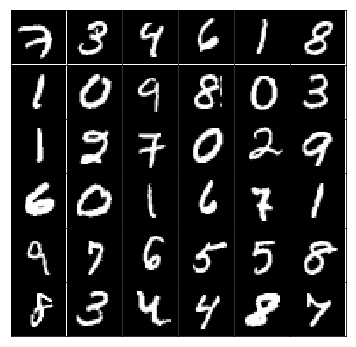

In [6]:
display_images(dataset.images())

## Wrapper functions

These are Tensorflow's wrapper function for the most important routines we will be using in this implementation. According to the paper, the variables are initialized with values from a normal distribution with *mean* of 0 and *standard deviation* of 0.02. Both convolutions and transpose convolutions have 'same' padding and they both use strides of 2 either to reduce in half or to double increase the inputs’ spatial dimensions.

In [7]:
def dense(x, out_units):
    return tf.layers.dense(x, out_units, activation=None,
                          kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

def conv2d(x, output_space):
    return tf.layers.conv2d(x, output_space, kernel_size=5, strides=2, padding="same", activation=None,
                           kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

def lrelu(x, alpha=0.2):
     # non-linear activation function
    return tf.maximum(alpha * x, x)

def batch_norm(x, training, epsilon=1e-5, momentum=0.9):
     return tf.layers.batch_normalization(x, training=training, epsilon=epsilon, momentum=momentum)
    
def transpose_conv2d(x, output_space):
    return tf.layers.conv2d_transpose(x, output_space, 5, strides=2, padding='same',
                                     kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

## Network Inputs

Here, just creating some placeholders to feed the Generator and Discriminator nets.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

The network has 4 convolutional layers, all of them followed by batch normalization (except for the output layer) and rectified linear unit (RELU) activations. It will take as input a random vector z (drawn from a normal distribution), which will be reshaped in a 4D tensor and start a series of upsampling layers by applying transpose convolutional operations with strides of 2.

All the transpose convolutions use kernel filters of size 5x5 and the kernel depth goes from 512 all the way down to 3 - representing the RGB color channels. The final layer then outputs a 32x32x3 tensor that will be squashed between -1 and 1 through the [Hyperbolic Tangent](https://reference.wolfram.com/language/ref/Tanh.html) function.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    """
    Generator network
    :param z: input random vector z
    :param output_dim: output dimension of the network
    :param reuse: Indicates whether or not the existing model variables should be used or recreated
    :param alpha: scalar for lrelu activation function
    :param training: Boolean for controlling the batch normalization statistics
    :return: model's output
    """
    with tf.variable_scope('generator', reuse=reuse):
        fc1 = dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        fc1 = tf.reshape(fc1, (-1, 4, 4, 512))
        fc1 = batch_norm(fc1, training=training)
        fc1 = tf.nn.relu(fc1)
        
        t_conv1 = transpose_conv2d(fc1, 256)
        t_conv1 = batch_norm(t_conv1, training=training)
        t_conv1 = tf.nn.relu(t_conv1)
        
        t_conv2 = transpose_conv2d(t_conv1, 128)
        t_conv2 = batch_norm(t_conv2, training=training)
        t_conv2 = tf.nn.relu(t_conv2)
        
        logits = transpose_conv2d(t_conv2, output_dim)
        
        out = tf.tanh(logits)
        return out

## Discriminator

The discriminator is also a 4 layer convolutional neural network followed by batch normalization (except its input layer) and leaky RELU activations. The network receives a 32x32x3 image tensor and performs regular convolutional operations with ‘same’ padding and strides of 2 - which basically double the size of the filters at each layer. Finally, the discriminator needs to output probabilities. For that, we use the Logistic [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function for the top layer.

In [10]:
def discriminator(x, reuse=False, alpha=0.2, training=True):
    """
    Discriminator network
    :param x: input for network
    :param reuse: Indicates whether or not the existing model variables should be used or recreated
    :param alpha: scalar for lrelu activation function
    :param training: Boolean for controlling the batch normalization statistics
    :return: A tuple of (sigmoid probabilities, logits)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x?
        conv1 = conv2d(x, 64)
        conv1 = lrelu(conv1, alpha)
        
        conv2 = conv2d(conv1, 128)
        conv2 = batch_norm(conv2, training=training)
        conv2 = lrelu(conv2, alpha)
        
        conv3 = conv2d(conv2, 256)
        conv3 = batch_norm(conv3, training=training)
        conv3 = lrelu(conv3, alpha)

        # Flatten it
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = dense(flat, 1)

        out = tf.sigmoid(logits)
        return out, logits

## Model Loss

We know that the discriminator receives images from both, the training set and from the generator. We want the discriminator to be able to distinguish between real and fake images. Since we want the discriminator to output probabilities close to 1 for real images and near 0 for fake images, we need two partial losses for the discriminator. The total loss for the discriminator is then, the sum of the two losses - one for maximizing the probabilities for the real images and another for minimizing the probability of fake images.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: random vector z
    :param out_channel_dim: The number of channels in the output image
    :param smooth: label smothing scalar 
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    tf.summary.scalar('mean_discriminator_output_prob_real', tf.reduce_mean(d_model_real))
        
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    tf.summary.scalar('mean_discriminator_output_prob_fake', tf.reduce_mean(d_model_fake))
    
    # for the real image from the training set, we want them to be classified as positives,  
    # so we want their labels to be all ones. 
    # notice here we use label smoothing for helping the discriminator to generalize better. 
    # Label smoothing works by avoiding the classifier to make extreme predictions when extrapolating.
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    # for the fake images produced by the generator, we want the discriminator to clissify them as false images,
    # so we set their labels to be all zeros.
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    # since the generator wants the discriminator to output 1s for its images, it uses the discriminator logits for the
    # fake images and assign labels of 1s to them.
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    tf.summary.scalar('generator_loss', g_loss)
    
    d_loss = d_loss_real + d_loss_fake
    tf.summary.scalar('discriminator_loss', d_loss)
    
    return d_loss, g_loss

## Optimizers

Because the generator and the discriminator networks train simultaneity, GANs require two optimizers to run at the same time. Each one for minimizing the discriminator and generator’s loss functions respectively.

In [12]:
def model_optimizers(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias variables for each network
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Because the batch norm layers are not part of the graph we inforce these operation to run before the 
    # optimizers so the batch normalization layers can update their population statistics.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

Set up the Hyperparameters.

In [13]:
real_size = dataset.images().shape[1:]
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

Get the placeholders from the helper functions and setup other variables.

In [14]:
tf.reset_default_graph()

input_real, input_z = model_inputs(real_size, z_size)
d_loss, g_loss = model_loss(input_real, input_z, real_size[2], alpha=0.2)
d_opt, g_opt = model_optimizers(d_loss, g_loss, learning_rate, 0.5)

sample_z = np.random.uniform(-1, 1, size=(36, z_size))

image_counter = 0

Dataset shuffled successfully.
Epoch 1/25... Discriminator Loss: 1.3892... Generator Loss: 0.3469


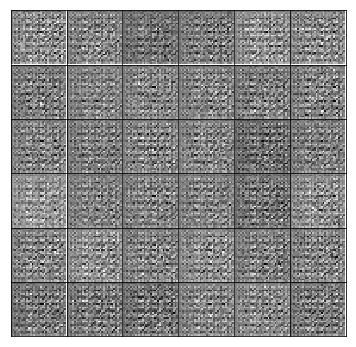

Epoch 1/25... Discriminator Loss: 2.2475... Generator Loss: 1.7226
Epoch 1/25... Discriminator Loss: 2.5848... Generator Loss: 1.0539
Epoch 1/25... Discriminator Loss: 1.8441... Generator Loss: 1.3266
Epoch 1/25... Discriminator Loss: 1.0919... Generator Loss: 1.9202
Epoch 1/25... Discriminator Loss: 1.2121... Generator Loss: 3.3178
Epoch 1/25... Discriminator Loss: 1.2156... Generator Loss: 1.5543
Epoch 1/25... Discriminator Loss: 0.9923... Generator Loss: 1.7721
Epoch 1/25... Discriminator Loss: 0.9970... Generator Loss: 2.9921
Epoch 1/25... Discriminator Loss: 1.0609... Generator Loss: 2.3654
Epoch 1/25... Discriminator Loss: 1.2223... Generator Loss: 1.0365


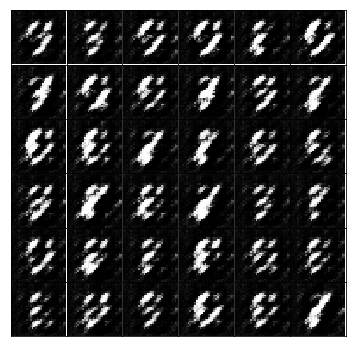

Epoch 1/25... Discriminator Loss: 1.1938... Generator Loss: 1.8441
Epoch 1/25... Discriminator Loss: 1.4071... Generator Loss: 2.1032
Epoch 1/25... Discriminator Loss: 1.5963... Generator Loss: 2.4574
Epoch 1/25... Discriminator Loss: 1.1875... Generator Loss: 1.7304
Epoch 1/25... Discriminator Loss: 1.2829... Generator Loss: 1.8367
Epoch 1/25... Discriminator Loss: 1.5374... Generator Loss: 2.2986
Epoch 1/25... Discriminator Loss: 1.1113... Generator Loss: 1.0021
Epoch 1/25... Discriminator Loss: 1.2942... Generator Loss: 1.2791
Epoch 1/25... Discriminator Loss: 1.4224... Generator Loss: 2.2071
Epoch 1/25... Discriminator Loss: 1.2414... Generator Loss: 1.0064


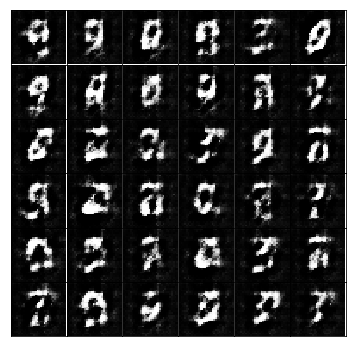

Epoch 1/25... Discriminator Loss: 1.7346... Generator Loss: 0.6283
Epoch 1/25... Discriminator Loss: 1.2487... Generator Loss: 1.4320
Epoch 1/25... Discriminator Loss: 1.1122... Generator Loss: 1.4730
Epoch 1/25... Discriminator Loss: 1.3228... Generator Loss: 1.0754
Epoch 1/25... Discriminator Loss: 1.2302... Generator Loss: 1.0396
Epoch 1/25... Discriminator Loss: 1.2507... Generator Loss: 1.1871
Epoch 1/25... Discriminator Loss: 1.3529... Generator Loss: 1.8056
Epoch 1/25... Discriminator Loss: 1.1687... Generator Loss: 1.0629
Epoch 1/25... Discriminator Loss: 1.1975... Generator Loss: 0.9767
Epoch 1/25... Discriminator Loss: 1.1763... Generator Loss: 0.9278


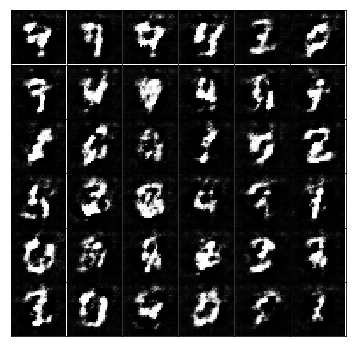

Epoch 1/25... Discriminator Loss: 1.1565... Generator Loss: 0.8738
Epoch 1/25... Discriminator Loss: 1.1550... Generator Loss: 1.5547
Epoch 1/25... Discriminator Loss: 1.2939... Generator Loss: 0.7543
Epoch 1/25... Discriminator Loss: 1.1368... Generator Loss: 0.7516
Epoch 1/25... Discriminator Loss: 1.1626... Generator Loss: 0.9179
Epoch 1/25... Discriminator Loss: 1.1226... Generator Loss: 1.1747
Epoch 1/25... Discriminator Loss: 1.0723... Generator Loss: 1.1052
Epoch 1/25... Discriminator Loss: 1.2896... Generator Loss: 0.5468
Epoch 1/25... Discriminator Loss: 1.1709... Generator Loss: 1.3568
Epoch 1/25... Discriminator Loss: 1.1749... Generator Loss: 1.0773


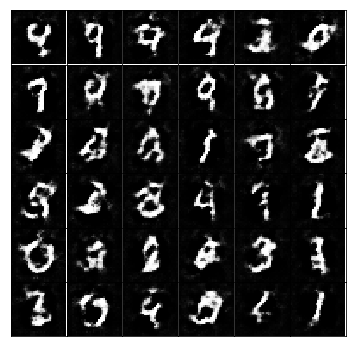

Epoch 1/25... Discriminator Loss: 1.2707... Generator Loss: 1.4976
Epoch 1/25... Discriminator Loss: 1.1797... Generator Loss: 0.8608
Epoch 1/25... Discriminator Loss: 1.2927... Generator Loss: 1.4468
Epoch 1/25... Discriminator Loss: 1.4023... Generator Loss: 1.5371
Epoch 1/25... Discriminator Loss: 1.2014... Generator Loss: 1.0112
Epoch 1/25... Discriminator Loss: 1.1634... Generator Loss: 0.8523
Epoch 1/25... Discriminator Loss: 1.2648... Generator Loss: 0.6616
Epoch 1/25... Discriminator Loss: 1.1626... Generator Loss: 0.8985
Epoch 1/25... Discriminator Loss: 1.7335... Generator Loss: 1.9690
Epoch 1/25... Discriminator Loss: 1.2402... Generator Loss: 0.8151


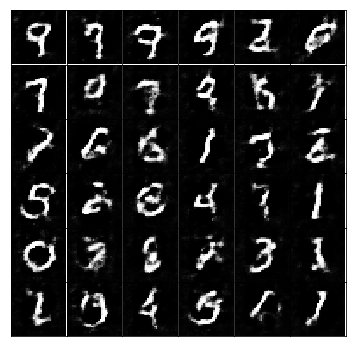

Dataset shuffled successfully.
Epoch 2/25... Discriminator Loss: 1.3567... Generator Loss: 1.8102
Epoch 2/25... Discriminator Loss: 1.1924... Generator Loss: 0.9218
Epoch 2/25... Discriminator Loss: 1.2760... Generator Loss: 1.0345
Epoch 2/25... Discriminator Loss: 1.3069... Generator Loss: 0.5730
Epoch 2/25... Discriminator Loss: 1.2579... Generator Loss: 0.6916
Epoch 2/25... Discriminator Loss: 1.2539... Generator Loss: 0.9159
Epoch 2/25... Discriminator Loss: 1.2406... Generator Loss: 0.7540
Epoch 2/25... Discriminator Loss: 1.4343... Generator Loss: 1.8963
Epoch 2/25... Discriminator Loss: 1.2252... Generator Loss: 1.0047
Epoch 2/25... Discriminator Loss: 1.2793... Generator Loss: 1.4291


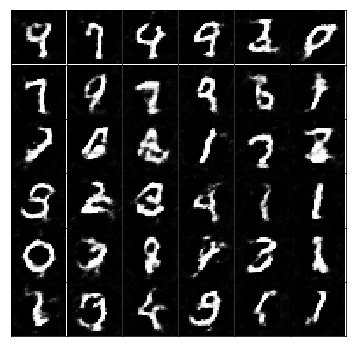

Epoch 2/25... Discriminator Loss: 1.1949... Generator Loss: 1.0606
Epoch 2/25... Discriminator Loss: 1.2892... Generator Loss: 0.9456
Epoch 2/25... Discriminator Loss: 1.2226... Generator Loss: 1.2372
Epoch 2/25... Discriminator Loss: 1.2414... Generator Loss: 1.0308
Epoch 2/25... Discriminator Loss: 1.2482... Generator Loss: 0.9711
Epoch 2/25... Discriminator Loss: 1.2865... Generator Loss: 1.3182
Epoch 2/25... Discriminator Loss: 1.2419... Generator Loss: 1.0321
Epoch 2/25... Discriminator Loss: 1.2069... Generator Loss: 0.8376
Epoch 2/25... Discriminator Loss: 1.2260... Generator Loss: 0.9748
Epoch 2/25... Discriminator Loss: 1.4226... Generator Loss: 1.6587


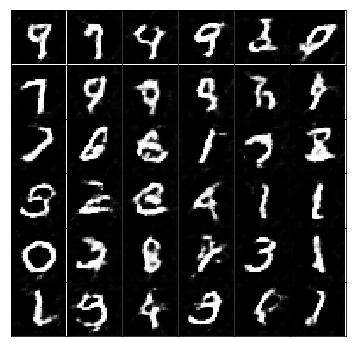

Epoch 2/25... Discriminator Loss: 1.2759... Generator Loss: 0.9812
Epoch 2/25... Discriminator Loss: 1.2212... Generator Loss: 1.0995
Epoch 2/25... Discriminator Loss: 1.2212... Generator Loss: 0.9981
Epoch 2/25... Discriminator Loss: 1.3480... Generator Loss: 0.6113
Epoch 2/25... Discriminator Loss: 1.2768... Generator Loss: 0.7826
Epoch 2/25... Discriminator Loss: 1.3342... Generator Loss: 0.5560
Epoch 2/25... Discriminator Loss: 1.2924... Generator Loss: 1.0408
Epoch 2/25... Discriminator Loss: 1.3070... Generator Loss: 0.7998
Epoch 2/25... Discriminator Loss: 1.2182... Generator Loss: 0.6286
Epoch 2/25... Discriminator Loss: 1.2494... Generator Loss: 0.8757


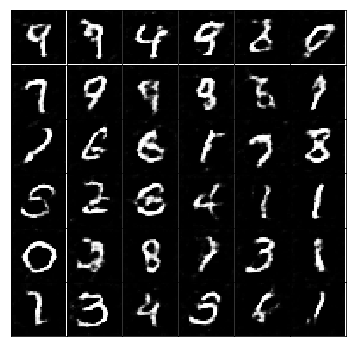

Epoch 2/25... Discriminator Loss: 1.1949... Generator Loss: 0.9466
Epoch 2/25... Discriminator Loss: 1.2731... Generator Loss: 0.9603
Epoch 2/25... Discriminator Loss: 1.2145... Generator Loss: 1.0698
Epoch 2/25... Discriminator Loss: 1.1984... Generator Loss: 0.7356
Epoch 2/25... Discriminator Loss: 1.2528... Generator Loss: 0.8551
Epoch 2/25... Discriminator Loss: 1.1989... Generator Loss: 0.9600
Epoch 2/25... Discriminator Loss: 1.2519... Generator Loss: 1.1008
Epoch 2/25... Discriminator Loss: 1.2594... Generator Loss: 1.0196
Epoch 2/25... Discriminator Loss: 1.2382... Generator Loss: 0.6273
Epoch 2/25... Discriminator Loss: 1.2261... Generator Loss: 1.0159


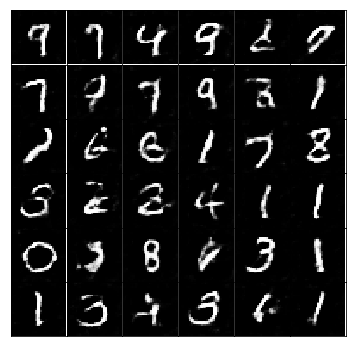

Epoch 2/25... Discriminator Loss: 1.2716... Generator Loss: 0.7511
Epoch 2/25... Discriminator Loss: 1.3660... Generator Loss: 0.5239
Epoch 2/25... Discriminator Loss: 1.2502... Generator Loss: 1.0737
Epoch 2/25... Discriminator Loss: 1.2588... Generator Loss: 1.4408
Epoch 2/25... Discriminator Loss: 1.2480... Generator Loss: 0.9441
Epoch 2/25... Discriminator Loss: 1.3170... Generator Loss: 0.9792
Epoch 2/25... Discriminator Loss: 1.3066... Generator Loss: 1.2719
Epoch 2/25... Discriminator Loss: 1.2314... Generator Loss: 0.9580
Epoch 2/25... Discriminator Loss: 1.3062... Generator Loss: 1.0195
Epoch 2/25... Discriminator Loss: 1.2440... Generator Loss: 0.8884


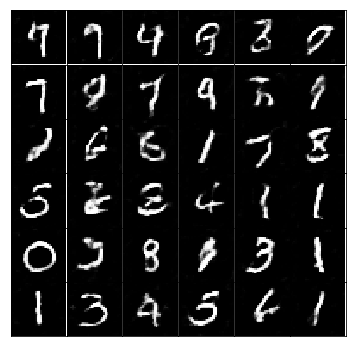

Epoch 2/25... Discriminator Loss: 1.2902... Generator Loss: 1.0429
Dataset shuffled successfully.
Epoch 3/25... Discriminator Loss: 1.2073... Generator Loss: 1.0063
Epoch 3/25... Discriminator Loss: 1.4800... Generator Loss: 0.4360
Epoch 3/25... Discriminator Loss: 1.3120... Generator Loss: 1.0614
Epoch 3/25... Discriminator Loss: 1.2679... Generator Loss: 0.7514
Epoch 3/25... Discriminator Loss: 1.1758... Generator Loss: 1.0264
Epoch 3/25... Discriminator Loss: 1.3227... Generator Loss: 0.7826
Epoch 3/25... Discriminator Loss: 1.4408... Generator Loss: 0.4238
Epoch 3/25... Discriminator Loss: 1.1921... Generator Loss: 0.9368
Epoch 3/25... Discriminator Loss: 1.2669... Generator Loss: 0.8407


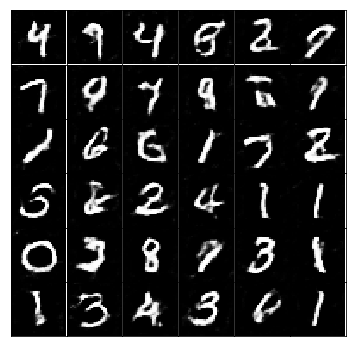

Epoch 3/25... Discriminator Loss: 1.3764... Generator Loss: 0.5785
Epoch 3/25... Discriminator Loss: 1.1837... Generator Loss: 1.0413
Epoch 3/25... Discriminator Loss: 1.2795... Generator Loss: 1.0188
Epoch 3/25... Discriminator Loss: 1.3430... Generator Loss: 1.6292
Epoch 3/25... Discriminator Loss: 1.3049... Generator Loss: 1.0237
Epoch 3/25... Discriminator Loss: 1.2153... Generator Loss: 1.0238
Epoch 3/25... Discriminator Loss: 1.2622... Generator Loss: 0.5806
Epoch 3/25... Discriminator Loss: 1.2787... Generator Loss: 0.6827
Epoch 3/25... Discriminator Loss: 1.2470... Generator Loss: 1.0336
Epoch 3/25... Discriminator Loss: 1.2402... Generator Loss: 0.8210


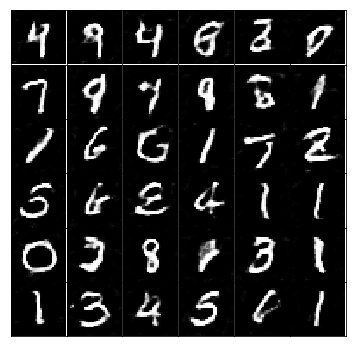

Epoch 3/25... Discriminator Loss: 1.2567... Generator Loss: 1.0436
Epoch 3/25... Discriminator Loss: 1.3024... Generator Loss: 0.6075
Epoch 3/25... Discriminator Loss: 1.2493... Generator Loss: 0.9810
Epoch 3/25... Discriminator Loss: 1.2408... Generator Loss: 1.0441
Epoch 3/25... Discriminator Loss: 1.3455... Generator Loss: 1.3819
Epoch 3/25... Discriminator Loss: 1.2339... Generator Loss: 0.9110
Epoch 3/25... Discriminator Loss: 1.3200... Generator Loss: 1.0463
Epoch 3/25... Discriminator Loss: 1.2258... Generator Loss: 0.7726
Epoch 3/25... Discriminator Loss: 1.2354... Generator Loss: 0.8693
Epoch 3/25... Discriminator Loss: 1.2612... Generator Loss: 1.0786


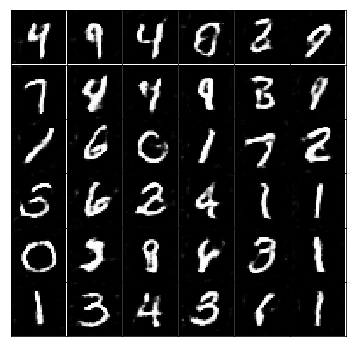

Epoch 3/25... Discriminator Loss: 1.2536... Generator Loss: 0.7130
Epoch 3/25... Discriminator Loss: 1.2180... Generator Loss: 0.9943
Epoch 3/25... Discriminator Loss: 1.3254... Generator Loss: 1.2394
Epoch 3/25... Discriminator Loss: 1.3577... Generator Loss: 0.6175
Epoch 3/25... Discriminator Loss: 1.2301... Generator Loss: 0.9881
Epoch 3/25... Discriminator Loss: 1.2602... Generator Loss: 0.7390
Epoch 3/25... Discriminator Loss: 1.2469... Generator Loss: 0.8113
Epoch 3/25... Discriminator Loss: 1.2729... Generator Loss: 0.6155
Epoch 3/25... Discriminator Loss: 1.2307... Generator Loss: 0.9687
Epoch 3/25... Discriminator Loss: 1.2714... Generator Loss: 0.9904


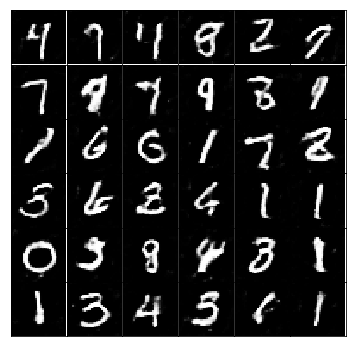

Epoch 3/25... Discriminator Loss: 1.4048... Generator Loss: 1.4568
Epoch 3/25... Discriminator Loss: 1.2577... Generator Loss: 0.9521
Epoch 3/25... Discriminator Loss: 1.2348... Generator Loss: 1.0530
Epoch 3/25... Discriminator Loss: 1.2509... Generator Loss: 0.9907
Epoch 3/25... Discriminator Loss: 1.2574... Generator Loss: 0.6842
Epoch 3/25... Discriminator Loss: 1.4267... Generator Loss: 1.8611
Epoch 3/25... Discriminator Loss: 1.2819... Generator Loss: 0.7580
Epoch 3/25... Discriminator Loss: 1.2295... Generator Loss: 0.8084
Epoch 3/25... Discriminator Loss: 1.1972... Generator Loss: 1.0794
Epoch 3/25... Discriminator Loss: 1.3255... Generator Loss: 0.4811


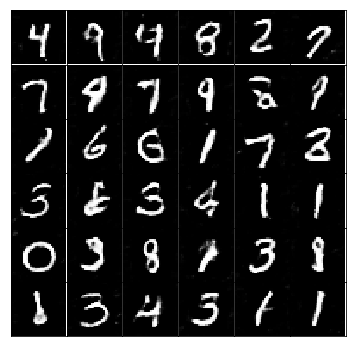

Epoch 3/25... Discriminator Loss: 1.2578... Generator Loss: 0.8332
Epoch 3/25... Discriminator Loss: 1.3591... Generator Loss: 1.1235
Dataset shuffled successfully.
Epoch 4/25... Discriminator Loss: 1.2425... Generator Loss: 1.1044
Epoch 4/25... Discriminator Loss: 1.2241... Generator Loss: 1.0100
Epoch 4/25... Discriminator Loss: 1.2205... Generator Loss: 1.1870
Epoch 4/25... Discriminator Loss: 1.2977... Generator Loss: 0.7771
Epoch 4/25... Discriminator Loss: 1.3029... Generator Loss: 1.1863
Epoch 4/25... Discriminator Loss: 1.2483... Generator Loss: 0.9568
Epoch 4/25... Discriminator Loss: 1.2216... Generator Loss: 0.8834
Epoch 4/25... Discriminator Loss: 1.2987... Generator Loss: 1.3499


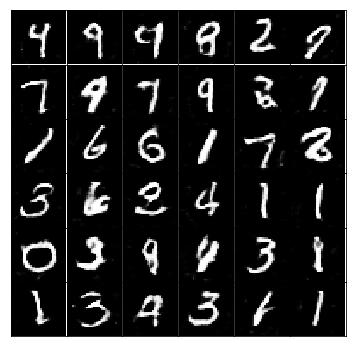

Epoch 4/25... Discriminator Loss: 1.3454... Generator Loss: 0.8639
Epoch 4/25... Discriminator Loss: 1.2716... Generator Loss: 0.8513
Epoch 4/25... Discriminator Loss: 1.2821... Generator Loss: 0.7647
Epoch 4/25... Discriminator Loss: 1.2428... Generator Loss: 0.6773
Epoch 4/25... Discriminator Loss: 1.2240... Generator Loss: 0.9768
Epoch 4/25... Discriminator Loss: 1.2459... Generator Loss: 0.8065
Epoch 4/25... Discriminator Loss: 1.2353... Generator Loss: 0.8385
Epoch 4/25... Discriminator Loss: 1.4566... Generator Loss: 1.9787
Epoch 4/25... Discriminator Loss: 1.2369... Generator Loss: 0.8003
Epoch 4/25... Discriminator Loss: 1.2600... Generator Loss: 0.6533


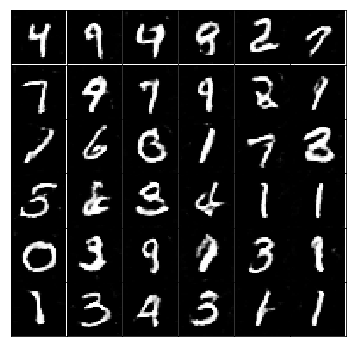

Epoch 4/25... Discriminator Loss: 1.3038... Generator Loss: 0.6995
Epoch 4/25... Discriminator Loss: 1.4396... Generator Loss: 1.3927
Epoch 4/25... Discriminator Loss: 1.3616... Generator Loss: 0.8126
Epoch 4/25... Discriminator Loss: 1.2369... Generator Loss: 0.8125
Epoch 4/25... Discriminator Loss: 1.2766... Generator Loss: 1.1369
Epoch 4/25... Discriminator Loss: 1.2974... Generator Loss: 1.0400
Epoch 4/25... Discriminator Loss: 1.2288... Generator Loss: 0.9300
Epoch 4/25... Discriminator Loss: 1.2787... Generator Loss: 1.0458
Epoch 4/25... Discriminator Loss: 1.3040... Generator Loss: 0.7225
Epoch 4/25... Discriminator Loss: 1.2906... Generator Loss: 1.0388


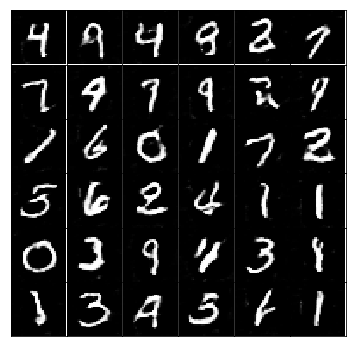

Epoch 4/25... Discriminator Loss: 1.1641... Generator Loss: 0.7877
Epoch 4/25... Discriminator Loss: 1.6629... Generator Loss: 0.3948
Epoch 4/25... Discriminator Loss: 1.3106... Generator Loss: 1.1417
Epoch 4/25... Discriminator Loss: 1.3052... Generator Loss: 0.6347
Epoch 4/25... Discriminator Loss: 1.3341... Generator Loss: 1.1590
Epoch 4/25... Discriminator Loss: 1.3292... Generator Loss: 0.4520
Epoch 4/25... Discriminator Loss: 1.2382... Generator Loss: 0.9105
Epoch 4/25... Discriminator Loss: 1.3290... Generator Loss: 1.2267
Epoch 4/25... Discriminator Loss: 1.2345... Generator Loss: 0.8628
Epoch 4/25... Discriminator Loss: 1.3842... Generator Loss: 1.7938


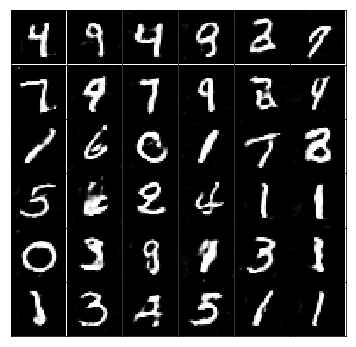

Epoch 4/25... Discriminator Loss: 1.2049... Generator Loss: 0.8156
Epoch 4/25... Discriminator Loss: 1.2250... Generator Loss: 0.8439
Epoch 4/25... Discriminator Loss: 1.2313... Generator Loss: 0.9486
Epoch 4/25... Discriminator Loss: 1.3347... Generator Loss: 0.5673
Epoch 4/25... Discriminator Loss: 1.2864... Generator Loss: 1.6046
Epoch 4/25... Discriminator Loss: 1.3687... Generator Loss: 0.6515
Epoch 4/25... Discriminator Loss: 1.2694... Generator Loss: 0.6142
Epoch 4/25... Discriminator Loss: 1.2249... Generator Loss: 0.9312
Epoch 4/25... Discriminator Loss: 1.3134... Generator Loss: 0.7239
Epoch 4/25... Discriminator Loss: 1.2087... Generator Loss: 0.8410


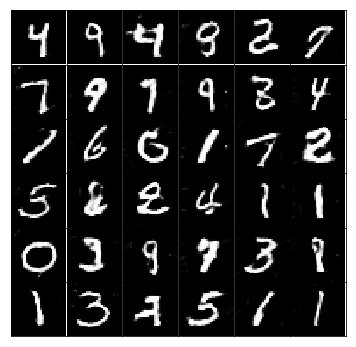

Epoch 4/25... Discriminator Loss: 1.1928... Generator Loss: 0.8631
Epoch 4/25... Discriminator Loss: 1.3032... Generator Loss: 0.7400
Epoch 4/25... Discriminator Loss: 1.2105... Generator Loss: 0.7833
Dataset shuffled successfully.
Epoch 5/25... Discriminator Loss: 1.4373... Generator Loss: 0.8486
Epoch 5/25... Discriminator Loss: 1.2175... Generator Loss: 0.9234
Epoch 5/25... Discriminator Loss: 1.2581... Generator Loss: 0.5961
Epoch 5/25... Discriminator Loss: 1.1807... Generator Loss: 0.8173
Epoch 5/25... Discriminator Loss: 1.4052... Generator Loss: 0.3972
Epoch 5/25... Discriminator Loss: 1.2238... Generator Loss: 0.7519
Epoch 5/25... Discriminator Loss: 1.3252... Generator Loss: 0.7026


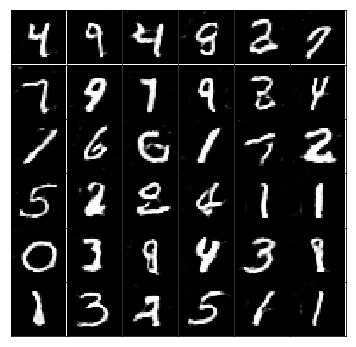

Epoch 5/25... Discriminator Loss: 1.3026... Generator Loss: 0.9289
Epoch 5/25... Discriminator Loss: 1.2692... Generator Loss: 0.6600
Epoch 5/25... Discriminator Loss: 1.2773... Generator Loss: 1.2994
Epoch 5/25... Discriminator Loss: 1.3508... Generator Loss: 1.5612
Epoch 5/25... Discriminator Loss: 1.2936... Generator Loss: 1.0618
Epoch 5/25... Discriminator Loss: 1.2994... Generator Loss: 0.9665
Epoch 5/25... Discriminator Loss: 1.1966... Generator Loss: 0.8235
Epoch 5/25... Discriminator Loss: 1.3584... Generator Loss: 0.6147
Epoch 5/25... Discriminator Loss: 1.2373... Generator Loss: 0.9357
Epoch 5/25... Discriminator Loss: 1.2755... Generator Loss: 1.2724


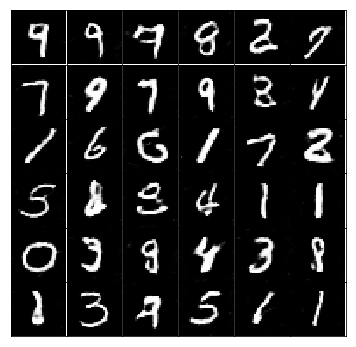

Epoch 5/25... Discriminator Loss: 1.2902... Generator Loss: 0.6382
Epoch 5/25... Discriminator Loss: 1.2108... Generator Loss: 1.1234
Epoch 5/25... Discriminator Loss: 1.1831... Generator Loss: 0.7655
Epoch 5/25... Discriminator Loss: 1.2754... Generator Loss: 0.6687
Epoch 5/25... Discriminator Loss: 1.2783... Generator Loss: 0.9456
Epoch 5/25... Discriminator Loss: 1.3448... Generator Loss: 1.2987
Epoch 5/25... Discriminator Loss: 1.2581... Generator Loss: 1.2543
Epoch 5/25... Discriminator Loss: 1.3698... Generator Loss: 0.6718
Epoch 5/25... Discriminator Loss: 1.2707... Generator Loss: 0.7375
Epoch 5/25... Discriminator Loss: 1.1915... Generator Loss: 0.6575


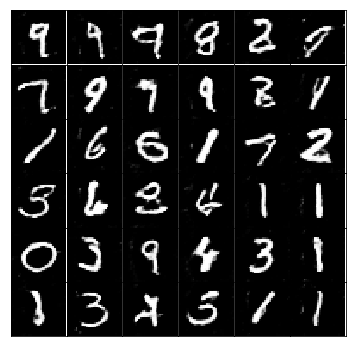

Epoch 5/25... Discriminator Loss: 1.2009... Generator Loss: 0.9771
Epoch 5/25... Discriminator Loss: 1.2766... Generator Loss: 0.9914
Epoch 5/25... Discriminator Loss: 1.2923... Generator Loss: 0.6087
Epoch 5/25... Discriminator Loss: 1.2022... Generator Loss: 0.9264
Epoch 5/25... Discriminator Loss: 1.2988... Generator Loss: 0.6894
Epoch 5/25... Discriminator Loss: 1.2358... Generator Loss: 0.5622
Epoch 5/25... Discriminator Loss: 1.3973... Generator Loss: 0.6666
Epoch 5/25... Discriminator Loss: 1.2682... Generator Loss: 0.7311
Epoch 5/25... Discriminator Loss: 1.2027... Generator Loss: 0.7243
Epoch 5/25... Discriminator Loss: 1.2301... Generator Loss: 0.5555


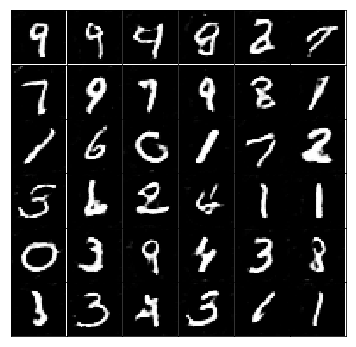

Epoch 5/25... Discriminator Loss: 1.1805... Generator Loss: 0.8375
Epoch 5/25... Discriminator Loss: 1.2313... Generator Loss: 1.1127
Epoch 5/25... Discriminator Loss: 1.2741... Generator Loss: 0.8058
Epoch 5/25... Discriminator Loss: 1.2981... Generator Loss: 0.6765
Epoch 5/25... Discriminator Loss: 1.3588... Generator Loss: 0.7687
Epoch 5/25... Discriminator Loss: 1.2306... Generator Loss: 0.7468
Epoch 5/25... Discriminator Loss: 1.3167... Generator Loss: 0.4670
Epoch 5/25... Discriminator Loss: 1.2438... Generator Loss: 1.1216
Epoch 5/25... Discriminator Loss: 1.3577... Generator Loss: 0.4921
Epoch 5/25... Discriminator Loss: 1.1600... Generator Loss: 1.0023


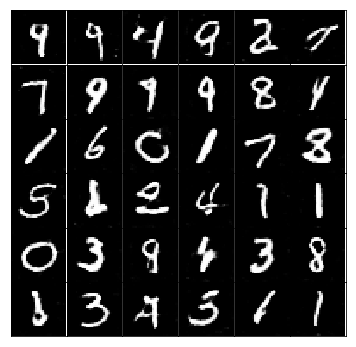

Epoch 5/25... Discriminator Loss: 1.1909... Generator Loss: 0.7962
Epoch 5/25... Discriminator Loss: 1.1860... Generator Loss: 0.9597
Epoch 5/25... Discriminator Loss: 1.2420... Generator Loss: 0.5659
Dataset shuffled successfully.
Epoch 6/25... Discriminator Loss: 1.3671... Generator Loss: 1.4694
Epoch 6/25... Discriminator Loss: 1.2078... Generator Loss: 0.7275
Epoch 6/25... Discriminator Loss: 1.1403... Generator Loss: 0.6942
Epoch 6/25... Discriminator Loss: 1.2498... Generator Loss: 0.5964
Epoch 6/25... Discriminator Loss: 1.5302... Generator Loss: 0.5548
Epoch 6/25... Discriminator Loss: 1.2070... Generator Loss: 0.6001
Epoch 6/25... Discriminator Loss: 1.3572... Generator Loss: 1.2319


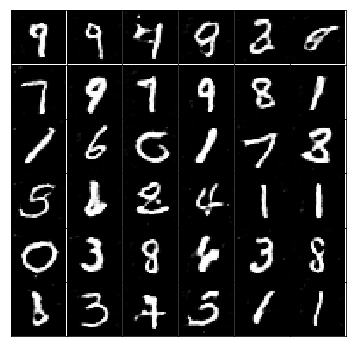

Epoch 6/25... Discriminator Loss: 1.3023... Generator Loss: 0.9777
Epoch 6/25... Discriminator Loss: 1.3109... Generator Loss: 0.8460
Epoch 6/25... Discriminator Loss: 1.2435... Generator Loss: 0.9531
Epoch 6/25... Discriminator Loss: 1.2298... Generator Loss: 0.8295
Epoch 6/25... Discriminator Loss: 1.4707... Generator Loss: 1.2527
Epoch 6/25... Discriminator Loss: 1.2094... Generator Loss: 1.0736
Epoch 6/25... Discriminator Loss: 1.1807... Generator Loss: 0.6342
Epoch 6/25... Discriminator Loss: 1.3390... Generator Loss: 0.8571
Epoch 6/25... Discriminator Loss: 1.1887... Generator Loss: 1.1446
Epoch 6/25... Discriminator Loss: 1.2223... Generator Loss: 0.5278


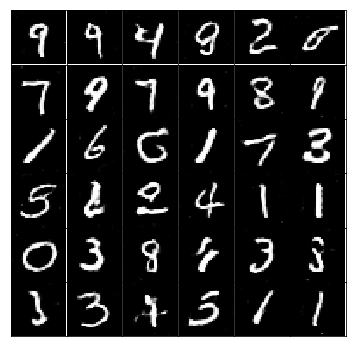

Epoch 6/25... Discriminator Loss: 1.2828... Generator Loss: 0.8499
Epoch 6/25... Discriminator Loss: 1.2468... Generator Loss: 0.6522
Epoch 6/25... Discriminator Loss: 1.2029... Generator Loss: 0.7987
Epoch 6/25... Discriminator Loss: 1.3560... Generator Loss: 0.7181
Epoch 6/25... Discriminator Loss: 1.1601... Generator Loss: 0.8479
Epoch 6/25... Discriminator Loss: 1.2259... Generator Loss: 0.6348
Epoch 6/25... Discriminator Loss: 1.2926... Generator Loss: 0.8205
Epoch 6/25... Discriminator Loss: 1.2661... Generator Loss: 0.9026
Epoch 6/25... Discriminator Loss: 1.2295... Generator Loss: 0.9701
Epoch 6/25... Discriminator Loss: 1.1451... Generator Loss: 0.8270


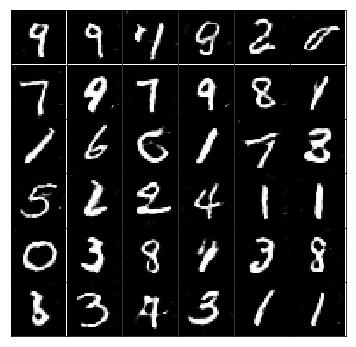

Epoch 6/25... Discriminator Loss: 1.2477... Generator Loss: 0.7673
Epoch 6/25... Discriminator Loss: 1.2404... Generator Loss: 0.4405
Epoch 6/25... Discriminator Loss: 1.2422... Generator Loss: 1.0676
Epoch 6/25... Discriminator Loss: 1.2749... Generator Loss: 0.8640
Epoch 6/25... Discriminator Loss: 1.2710... Generator Loss: 0.9932
Epoch 6/25... Discriminator Loss: 1.2975... Generator Loss: 1.5094
Epoch 6/25... Discriminator Loss: 1.2019... Generator Loss: 0.7663
Epoch 6/25... Discriminator Loss: 1.1856... Generator Loss: 0.7892
Epoch 6/25... Discriminator Loss: 1.2247... Generator Loss: 0.8085
Epoch 6/25... Discriminator Loss: 1.3167... Generator Loss: 1.2621


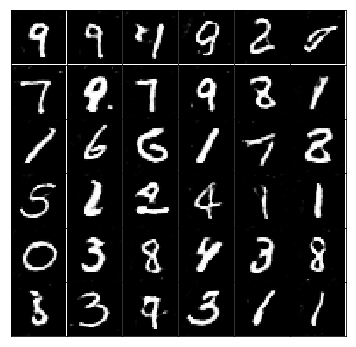

Epoch 6/25... Discriminator Loss: 1.1755... Generator Loss: 0.9509
Epoch 6/25... Discriminator Loss: 1.2474... Generator Loss: 0.7369
Epoch 6/25... Discriminator Loss: 1.1158... Generator Loss: 0.9369
Epoch 6/25... Discriminator Loss: 1.2302... Generator Loss: 0.7974
Epoch 6/25... Discriminator Loss: 1.2296... Generator Loss: 0.8811
Epoch 6/25... Discriminator Loss: 1.3336... Generator Loss: 0.9421
Epoch 6/25... Discriminator Loss: 1.2911... Generator Loss: 0.5382
Epoch 6/25... Discriminator Loss: 1.2035... Generator Loss: 0.6479
Epoch 6/25... Discriminator Loss: 1.4268... Generator Loss: 1.4758
Epoch 6/25... Discriminator Loss: 1.2101... Generator Loss: 0.8132


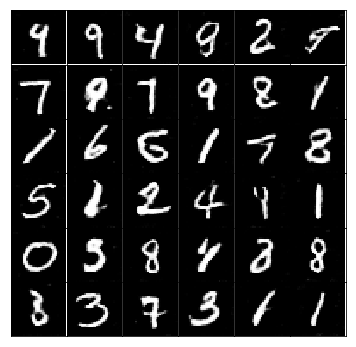

Epoch 6/25... Discriminator Loss: 1.2830... Generator Loss: 1.2683
Epoch 6/25... Discriminator Loss: 1.2145... Generator Loss: 0.8767
Epoch 6/25... Discriminator Loss: 1.1644... Generator Loss: 1.0332
Epoch 6/25... Discriminator Loss: 1.2159... Generator Loss: 0.9755
Dataset shuffled successfully.
Epoch 7/25... Discriminator Loss: 1.0889... Generator Loss: 0.8822
Epoch 7/25... Discriminator Loss: 1.2593... Generator Loss: 0.3969
Epoch 7/25... Discriminator Loss: 1.1828... Generator Loss: 0.8117
Epoch 7/25... Discriminator Loss: 1.2707... Generator Loss: 0.5428
Epoch 7/25... Discriminator Loss: 1.2445... Generator Loss: 0.7298
Epoch 7/25... Discriminator Loss: 1.2335... Generator Loss: 0.7463


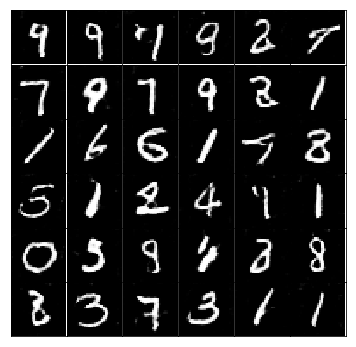

Epoch 7/25... Discriminator Loss: 1.4228... Generator Loss: 0.4433
Epoch 7/25... Discriminator Loss: 1.1646... Generator Loss: 0.8313
Epoch 7/25... Discriminator Loss: 1.1615... Generator Loss: 0.7079
Epoch 7/25... Discriminator Loss: 1.3757... Generator Loss: 0.9299
Epoch 7/25... Discriminator Loss: 1.2344... Generator Loss: 0.8473
Epoch 7/25... Discriminator Loss: 1.2614... Generator Loss: 0.6601
Epoch 7/25... Discriminator Loss: 1.2080... Generator Loss: 0.6374
Epoch 7/25... Discriminator Loss: 1.3190... Generator Loss: 0.5969
Epoch 7/25... Discriminator Loss: 1.4471... Generator Loss: 1.4324
Epoch 7/25... Discriminator Loss: 1.2076... Generator Loss: 0.7372


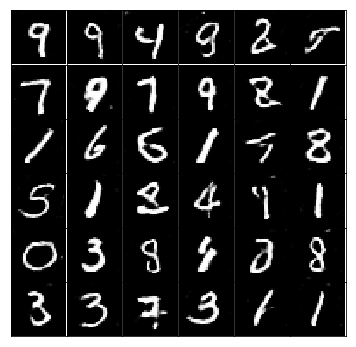

Epoch 7/25... Discriminator Loss: 1.2592... Generator Loss: 0.6002
Epoch 7/25... Discriminator Loss: 1.1940... Generator Loss: 0.7266
Epoch 7/25... Discriminator Loss: 1.1124... Generator Loss: 0.8262
Epoch 7/25... Discriminator Loss: 1.2374... Generator Loss: 1.0893
Epoch 7/25... Discriminator Loss: 1.1174... Generator Loss: 1.1126
Epoch 7/25... Discriminator Loss: 1.2570... Generator Loss: 0.8570
Epoch 7/25... Discriminator Loss: 1.2232... Generator Loss: 0.6861
Epoch 7/25... Discriminator Loss: 1.1908... Generator Loss: 0.8033
Epoch 7/25... Discriminator Loss: 1.1759... Generator Loss: 0.8038
Epoch 7/25... Discriminator Loss: 1.2517... Generator Loss: 0.7314


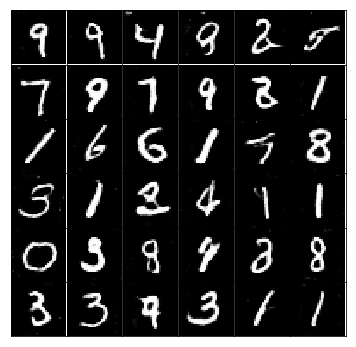

Epoch 7/25... Discriminator Loss: 1.4406... Generator Loss: 1.4330
Epoch 7/25... Discriminator Loss: 1.2658... Generator Loss: 1.3186
Epoch 7/25... Discriminator Loss: 1.2087... Generator Loss: 1.1824
Epoch 7/25... Discriminator Loss: 1.1887... Generator Loss: 1.3415
Epoch 7/25... Discriminator Loss: 1.5484... Generator Loss: 1.5103
Epoch 7/25... Discriminator Loss: 1.1783... Generator Loss: 0.7582
Epoch 7/25... Discriminator Loss: 1.1875... Generator Loss: 0.7280
Epoch 7/25... Discriminator Loss: 1.1311... Generator Loss: 0.8235
Epoch 7/25... Discriminator Loss: 1.2180... Generator Loss: 0.4575
Epoch 7/25... Discriminator Loss: 1.1983... Generator Loss: 0.6132


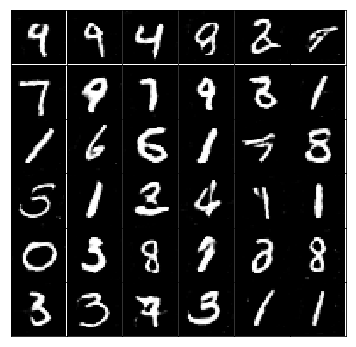

Epoch 7/25... Discriminator Loss: 1.4933... Generator Loss: 1.5799
Epoch 7/25... Discriminator Loss: 1.2308... Generator Loss: 0.6673
Epoch 7/25... Discriminator Loss: 1.2362... Generator Loss: 0.7491
Epoch 7/25... Discriminator Loss: 1.1856... Generator Loss: 0.6709
Epoch 7/25... Discriminator Loss: 1.1326... Generator Loss: 0.8815
Epoch 7/25... Discriminator Loss: 1.1774... Generator Loss: 0.8895
Epoch 7/25... Discriminator Loss: 1.2523... Generator Loss: 1.0026
Epoch 7/25... Discriminator Loss: 1.2771... Generator Loss: 0.5936
Epoch 7/25... Discriminator Loss: 1.2936... Generator Loss: 0.8121
Epoch 7/25... Discriminator Loss: 1.2083... Generator Loss: 0.5372


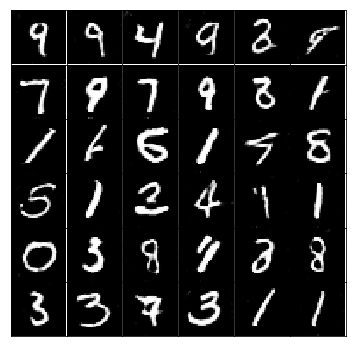

Epoch 7/25... Discriminator Loss: 1.0839... Generator Loss: 0.6993
Epoch 7/25... Discriminator Loss: 1.2310... Generator Loss: 1.1603
Epoch 7/25... Discriminator Loss: 1.2096... Generator Loss: 0.4732
Epoch 7/25... Discriminator Loss: 1.1572... Generator Loss: 0.8863
Epoch 7/25... Discriminator Loss: 1.3094... Generator Loss: 0.8743
Dataset shuffled successfully.
Epoch 8/25... Discriminator Loss: 1.2203... Generator Loss: 0.9550
Epoch 8/25... Discriminator Loss: 1.1798... Generator Loss: 1.1513
Epoch 8/25... Discriminator Loss: 1.1447... Generator Loss: 0.7020
Epoch 8/25... Discriminator Loss: 1.1531... Generator Loss: 0.6251
Epoch 8/25... Discriminator Loss: 1.1907... Generator Loss: 0.7516


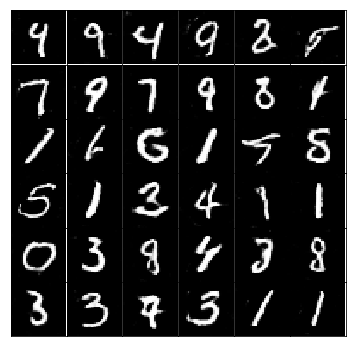

Epoch 8/25... Discriminator Loss: 1.1617... Generator Loss: 0.7269
Epoch 8/25... Discriminator Loss: 1.2183... Generator Loss: 0.6232
Epoch 8/25... Discriminator Loss: 1.2352... Generator Loss: 0.9405
Epoch 8/25... Discriminator Loss: 1.0999... Generator Loss: 0.8488
Epoch 8/25... Discriminator Loss: 1.2196... Generator Loss: 0.9272
Epoch 8/25... Discriminator Loss: 1.2749... Generator Loss: 0.7575
Epoch 8/25... Discriminator Loss: 1.4264... Generator Loss: 1.7048
Epoch 8/25... Discriminator Loss: 1.1610... Generator Loss: 0.8444
Epoch 8/25... Discriminator Loss: 1.1869... Generator Loss: 0.6688
Epoch 8/25... Discriminator Loss: 1.1689... Generator Loss: 0.8261


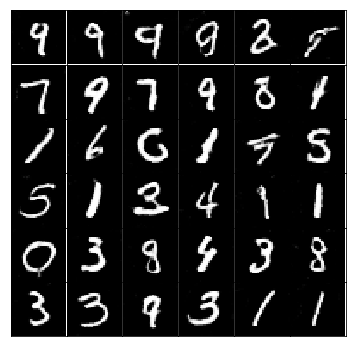

Epoch 8/25... Discriminator Loss: 1.1559... Generator Loss: 0.6280
Epoch 8/25... Discriminator Loss: 1.2008... Generator Loss: 0.9419
Epoch 8/25... Discriminator Loss: 1.2292... Generator Loss: 0.9899
Epoch 8/25... Discriminator Loss: 1.1306... Generator Loss: 0.9827
Epoch 8/25... Discriminator Loss: 1.2325... Generator Loss: 0.8415
Epoch 8/25... Discriminator Loss: 1.1693... Generator Loss: 0.8615
Epoch 8/25... Discriminator Loss: 1.2519... Generator Loss: 0.7547
Epoch 8/25... Discriminator Loss: 1.1761... Generator Loss: 0.4769
Epoch 8/25... Discriminator Loss: 1.2809... Generator Loss: 0.9231
Epoch 8/25... Discriminator Loss: 1.2646... Generator Loss: 1.0704


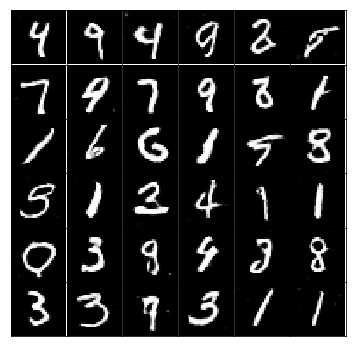

Epoch 8/25... Discriminator Loss: 1.1564... Generator Loss: 1.0065
Epoch 8/25... Discriminator Loss: 1.2348... Generator Loss: 0.5885
Epoch 8/25... Discriminator Loss: 1.1497... Generator Loss: 0.6883
Epoch 8/25... Discriminator Loss: 1.1524... Generator Loss: 0.8626
Epoch 8/25... Discriminator Loss: 1.2095... Generator Loss: 0.8046
Epoch 8/25... Discriminator Loss: 1.2020... Generator Loss: 0.6491
Epoch 8/25... Discriminator Loss: 1.4625... Generator Loss: 0.6347
Epoch 8/25... Discriminator Loss: 1.2614... Generator Loss: 1.1618
Epoch 8/25... Discriminator Loss: 1.2289... Generator Loss: 0.7397
Epoch 8/25... Discriminator Loss: 1.3287... Generator Loss: 0.9590


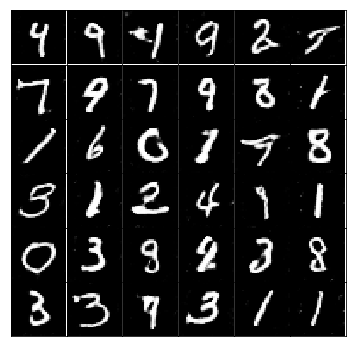

Epoch 8/25... Discriminator Loss: 1.2647... Generator Loss: 0.6169
Epoch 8/25... Discriminator Loss: 1.2794... Generator Loss: 0.7323
Epoch 8/25... Discriminator Loss: 1.1504... Generator Loss: 0.8648
Epoch 8/25... Discriminator Loss: 1.2171... Generator Loss: 0.5885
Epoch 8/25... Discriminator Loss: 1.2566... Generator Loss: 0.5894
Epoch 8/25... Discriminator Loss: 1.2229... Generator Loss: 1.1863
Epoch 8/25... Discriminator Loss: 1.2062... Generator Loss: 1.0746
Epoch 8/25... Discriminator Loss: 1.2457... Generator Loss: 1.1399
Epoch 8/25... Discriminator Loss: 1.4997... Generator Loss: 0.4030
Epoch 8/25... Discriminator Loss: 1.2349... Generator Loss: 0.9023


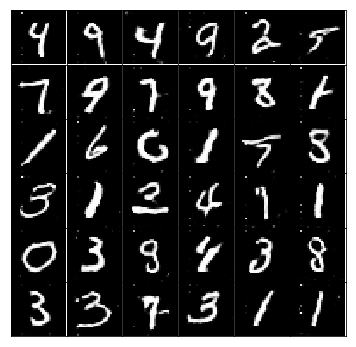

Epoch 8/25... Discriminator Loss: 1.2305... Generator Loss: 1.3588
Epoch 8/25... Discriminator Loss: 1.0580... Generator Loss: 0.8319
Epoch 8/25... Discriminator Loss: 1.1260... Generator Loss: 0.8665
Epoch 8/25... Discriminator Loss: 1.1313... Generator Loss: 0.7654
Epoch 8/25... Discriminator Loss: 1.1686... Generator Loss: 0.8065
Epoch 8/25... Discriminator Loss: 1.2659... Generator Loss: 0.5671
Dataset shuffled successfully.
Epoch 9/25... Discriminator Loss: 1.2521... Generator Loss: 0.6922
Epoch 9/25... Discriminator Loss: 1.3299... Generator Loss: 0.3125
Epoch 9/25... Discriminator Loss: 1.2926... Generator Loss: 0.7530
Epoch 9/25... Discriminator Loss: 1.1920... Generator Loss: 0.7693


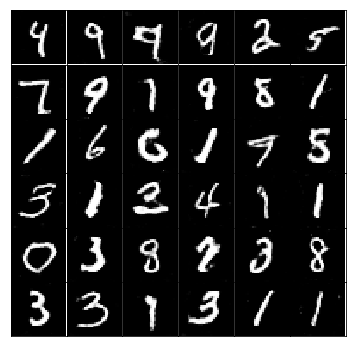

Epoch 9/25... Discriminator Loss: 1.0865... Generator Loss: 1.1146
Epoch 9/25... Discriminator Loss: 1.1722... Generator Loss: 0.5562
Epoch 9/25... Discriminator Loss: 1.3513... Generator Loss: 0.4568
Epoch 9/25... Discriminator Loss: 1.1397... Generator Loss: 1.0622
Epoch 9/25... Discriminator Loss: 1.1615... Generator Loss: 0.8305
Epoch 9/25... Discriminator Loss: 1.2889... Generator Loss: 0.8837
Epoch 9/25... Discriminator Loss: 1.1249... Generator Loss: 1.1064
Epoch 9/25... Discriminator Loss: 1.1014... Generator Loss: 0.7102
Epoch 9/25... Discriminator Loss: 1.1392... Generator Loss: 0.5833
Epoch 9/25... Discriminator Loss: 1.2552... Generator Loss: 0.5277


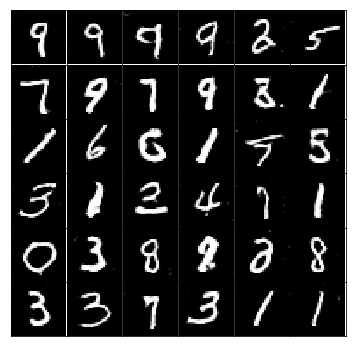

Epoch 9/25... Discriminator Loss: 1.2879... Generator Loss: 0.6916
Epoch 9/25... Discriminator Loss: 1.2204... Generator Loss: 0.9875
Epoch 9/25... Discriminator Loss: 1.1129... Generator Loss: 0.8288
Epoch 9/25... Discriminator Loss: 1.1648... Generator Loss: 0.5320
Epoch 9/25... Discriminator Loss: 1.1692... Generator Loss: 0.7951
Epoch 9/25... Discriminator Loss: 1.0770... Generator Loss: 0.9932
Epoch 9/25... Discriminator Loss: 1.1280... Generator Loss: 0.3883
Epoch 9/25... Discriminator Loss: 1.2296... Generator Loss: 1.1143
Epoch 9/25... Discriminator Loss: 1.2056... Generator Loss: 1.1349
Epoch 9/25... Discriminator Loss: 1.1843... Generator Loss: 1.0490


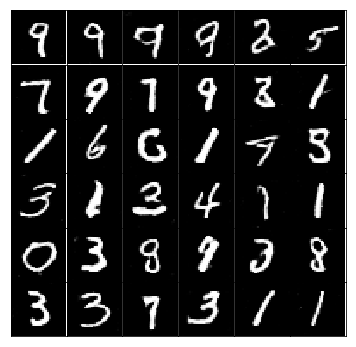

Epoch 9/25... Discriminator Loss: 1.1458... Generator Loss: 0.8009
Epoch 9/25... Discriminator Loss: 1.0806... Generator Loss: 0.8381
Epoch 9/25... Discriminator Loss: 1.0816... Generator Loss: 1.0370
Epoch 9/25... Discriminator Loss: 1.0772... Generator Loss: 0.8595
Epoch 9/25... Discriminator Loss: 1.0926... Generator Loss: 1.1406
Epoch 9/25... Discriminator Loss: 1.1010... Generator Loss: 0.8943
Epoch 9/25... Discriminator Loss: 1.1532... Generator Loss: 0.3095
Epoch 9/25... Discriminator Loss: 1.1503... Generator Loss: 0.8301
Epoch 9/25... Discriminator Loss: 1.4642... Generator Loss: 1.8557
Epoch 9/25... Discriminator Loss: 1.1720... Generator Loss: 0.8298


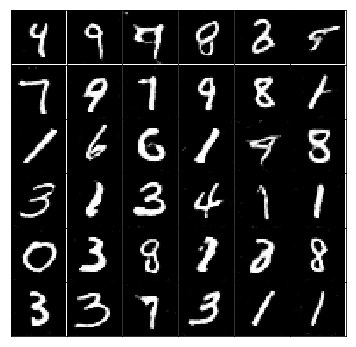

Epoch 9/25... Discriminator Loss: 1.0573... Generator Loss: 0.6646
Epoch 9/25... Discriminator Loss: 1.2499... Generator Loss: 1.1617
Epoch 9/25... Discriminator Loss: 1.1789... Generator Loss: 0.9737
Epoch 9/25... Discriminator Loss: 1.1133... Generator Loss: 0.7458
Epoch 9/25... Discriminator Loss: 1.2244... Generator Loss: 1.5114
Epoch 9/25... Discriminator Loss: 1.4820... Generator Loss: 0.7848
Epoch 9/25... Discriminator Loss: 1.1963... Generator Loss: 1.1667
Epoch 9/25... Discriminator Loss: 1.2084... Generator Loss: 1.5124
Epoch 9/25... Discriminator Loss: 1.1282... Generator Loss: 0.8866
Epoch 9/25... Discriminator Loss: 1.2002... Generator Loss: 0.8681


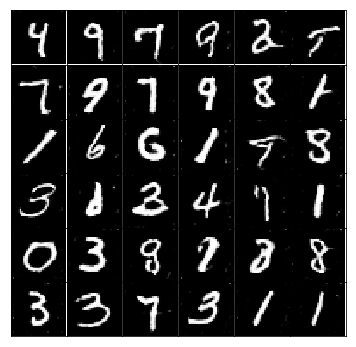

Epoch 9/25... Discriminator Loss: 1.1486... Generator Loss: 0.8576
Epoch 9/25... Discriminator Loss: 1.1145... Generator Loss: 0.9090
Epoch 9/25... Discriminator Loss: 1.1886... Generator Loss: 1.0224
Epoch 9/25... Discriminator Loss: 1.2640... Generator Loss: 1.2972
Epoch 9/25... Discriminator Loss: 1.1246... Generator Loss: 0.9257
Epoch 9/25... Discriminator Loss: 1.1522... Generator Loss: 0.6120
Epoch 9/25... Discriminator Loss: 1.4435... Generator Loss: 0.8041
Dataset shuffled successfully.
Epoch 10/25... Discriminator Loss: 1.1226... Generator Loss: 0.7801
Epoch 10/25... Discriminator Loss: 1.3009... Generator Loss: 0.4864
Epoch 10/25... Discriminator Loss: 1.1539... Generator Loss: 0.7204


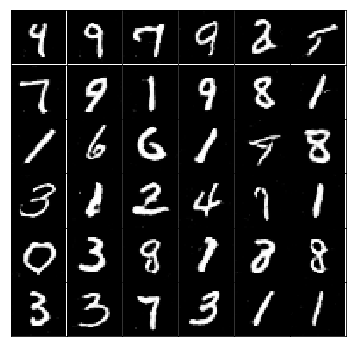

Epoch 10/25... Discriminator Loss: 1.0492... Generator Loss: 0.7386
Epoch 10/25... Discriminator Loss: 1.0975... Generator Loss: 0.7967
Epoch 10/25... Discriminator Loss: 1.1518... Generator Loss: 0.5689
Epoch 10/25... Discriminator Loss: 1.4349... Generator Loss: 0.6271
Epoch 10/25... Discriminator Loss: 1.2109... Generator Loss: 0.4469
Epoch 10/25... Discriminator Loss: 1.1323... Generator Loss: 0.4305
Epoch 10/25... Discriminator Loss: 1.2647... Generator Loss: 0.6342
Epoch 10/25... Discriminator Loss: 1.1025... Generator Loss: 0.9228
Epoch 10/25... Discriminator Loss: 1.1228... Generator Loss: 0.8005
Epoch 10/25... Discriminator Loss: 1.1825... Generator Loss: 0.8283


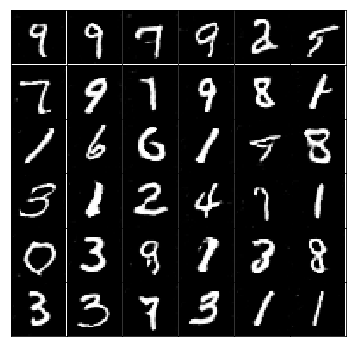

Epoch 10/25... Discriminator Loss: 1.0515... Generator Loss: 0.5557
Epoch 10/25... Discriminator Loss: 1.1412... Generator Loss: 1.0233
Epoch 10/25... Discriminator Loss: 1.1482... Generator Loss: 1.0570
Epoch 10/25... Discriminator Loss: 0.9850... Generator Loss: 0.6547
Epoch 10/25... Discriminator Loss: 1.1519... Generator Loss: 1.1049
Epoch 10/25... Discriminator Loss: 1.1794... Generator Loss: 0.7273
Epoch 10/25... Discriminator Loss: 1.3167... Generator Loss: 0.4681
Epoch 10/25... Discriminator Loss: 1.1976... Generator Loss: 0.4715
Epoch 10/25... Discriminator Loss: 1.1082... Generator Loss: 0.7192
Epoch 10/25... Discriminator Loss: 1.0857... Generator Loss: 1.1099


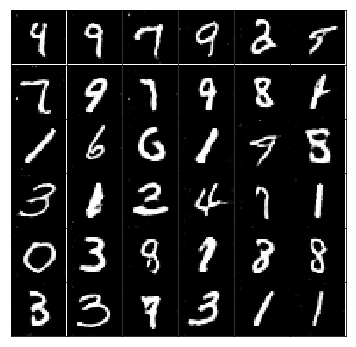

Epoch 10/25... Discriminator Loss: 1.0682... Generator Loss: 1.0894
Epoch 10/25... Discriminator Loss: 1.2470... Generator Loss: 0.5453
Epoch 10/25... Discriminator Loss: 1.6829... Generator Loss: 2.0560
Epoch 10/25... Discriminator Loss: 1.1912... Generator Loss: 0.6775
Epoch 10/25... Discriminator Loss: 1.1808... Generator Loss: 1.1736
Epoch 10/25... Discriminator Loss: 1.0110... Generator Loss: 0.9230
Epoch 10/25... Discriminator Loss: 1.0673... Generator Loss: 0.8412
Epoch 10/25... Discriminator Loss: 1.2371... Generator Loss: 0.6971
Epoch 10/25... Discriminator Loss: 1.0883... Generator Loss: 0.4873
Epoch 10/25... Discriminator Loss: 1.1332... Generator Loss: 0.9772


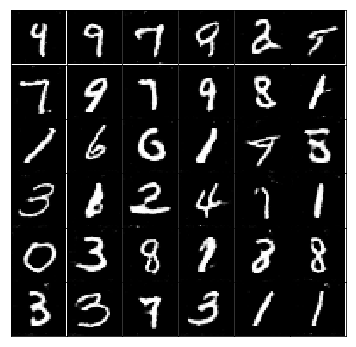

Epoch 10/25... Discriminator Loss: 1.0358... Generator Loss: 0.9203
Epoch 10/25... Discriminator Loss: 1.1028... Generator Loss: 0.5083
Epoch 10/25... Discriminator Loss: 1.0660... Generator Loss: 0.7440
Epoch 10/25... Discriminator Loss: 0.9620... Generator Loss: 0.7413
Epoch 10/25... Discriminator Loss: 1.4246... Generator Loss: 1.6504
Epoch 10/25... Discriminator Loss: 1.2051... Generator Loss: 0.4891
Epoch 10/25... Discriminator Loss: 1.1461... Generator Loss: 0.9239
Epoch 10/25... Discriminator Loss: 1.1573... Generator Loss: 0.8985
Epoch 10/25... Discriminator Loss: 1.5243... Generator Loss: 0.5527
Epoch 10/25... Discriminator Loss: 1.2289... Generator Loss: 0.4680


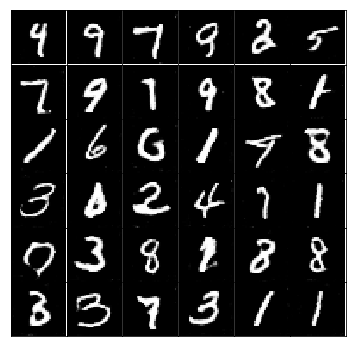

Epoch 10/25... Discriminator Loss: 1.1916... Generator Loss: 1.0251
Epoch 10/25... Discriminator Loss: 1.2979... Generator Loss: 0.3690
Epoch 10/25... Discriminator Loss: 1.1279... Generator Loss: 1.3483
Epoch 10/25... Discriminator Loss: 1.0946... Generator Loss: 0.8710
Epoch 10/25... Discriminator Loss: 1.1551... Generator Loss: 0.8267
Epoch 10/25... Discriminator Loss: 1.1448... Generator Loss: 0.9739
Epoch 10/25... Discriminator Loss: 1.2927... Generator Loss: 0.7343
Dataset shuffled successfully.
Epoch 11/25... Discriminator Loss: 1.2644... Generator Loss: 1.3084
Epoch 11/25... Discriminator Loss: 1.1445... Generator Loss: 0.6369
Epoch 11/25... Discriminator Loss: 1.2323... Generator Loss: 1.0662


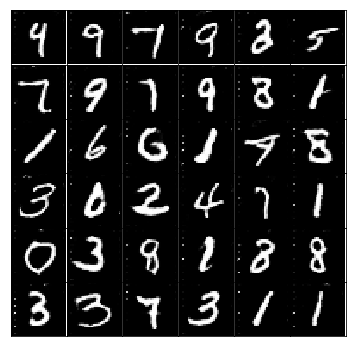

Epoch 11/25... Discriminator Loss: 1.1144... Generator Loss: 0.6837
Epoch 11/25... Discriminator Loss: 1.0415... Generator Loss: 0.8225
Epoch 11/25... Discriminator Loss: 1.1369... Generator Loss: 1.1072
Epoch 11/25... Discriminator Loss: 1.4423... Generator Loss: 0.4382
Epoch 11/25... Discriminator Loss: 1.0950... Generator Loss: 0.4558
Epoch 11/25... Discriminator Loss: 1.0886... Generator Loss: 0.9088
Epoch 11/25... Discriminator Loss: 1.1150... Generator Loss: 1.1321
Epoch 11/25... Discriminator Loss: 1.0913... Generator Loss: 0.7616
Epoch 11/25... Discriminator Loss: 1.1390... Generator Loss: 0.9201
Epoch 11/25... Discriminator Loss: 1.5405... Generator Loss: 0.5616


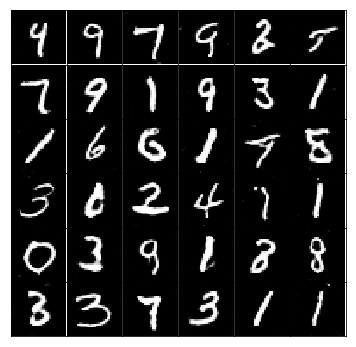

Epoch 11/25... Discriminator Loss: 1.1247... Generator Loss: 0.5071
Epoch 11/25... Discriminator Loss: 1.0936... Generator Loss: 1.2019
Epoch 11/25... Discriminator Loss: 1.3603... Generator Loss: 0.6903
Epoch 11/25... Discriminator Loss: 1.0058... Generator Loss: 0.9035
Epoch 11/25... Discriminator Loss: 1.0848... Generator Loss: 0.7928
Epoch 11/25... Discriminator Loss: 1.2700... Generator Loss: 1.4407
Epoch 11/25... Discriminator Loss: 1.2684... Generator Loss: 0.4316
Epoch 11/25... Discriminator Loss: 1.1040... Generator Loss: 1.2537
Epoch 11/25... Discriminator Loss: 1.1338... Generator Loss: 0.9668
Epoch 11/25... Discriminator Loss: 1.1789... Generator Loss: 1.4955


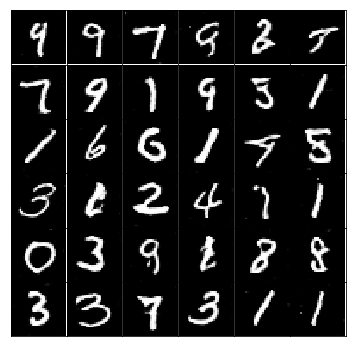

Epoch 11/25... Discriminator Loss: 1.0506... Generator Loss: 0.6774
Epoch 11/25... Discriminator Loss: 1.1504... Generator Loss: 0.5743
Epoch 11/25... Discriminator Loss: 1.2779... Generator Loss: 1.3716
Epoch 11/25... Discriminator Loss: 1.1084... Generator Loss: 0.8417
Epoch 11/25... Discriminator Loss: 1.2528... Generator Loss: 1.7426
Epoch 11/25... Discriminator Loss: 1.2004... Generator Loss: 0.8943
Epoch 11/25... Discriminator Loss: 1.2529... Generator Loss: 0.4787
Epoch 11/25... Discriminator Loss: 1.1832... Generator Loss: 0.4034
Epoch 11/25... Discriminator Loss: 1.1270... Generator Loss: 0.9344
Epoch 11/25... Discriminator Loss: 1.2151... Generator Loss: 1.1151


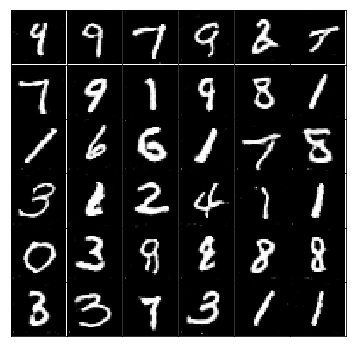

Epoch 11/25... Discriminator Loss: 1.0356... Generator Loss: 0.7962
Epoch 11/25... Discriminator Loss: 1.0829... Generator Loss: 0.4635
Epoch 11/25... Discriminator Loss: 1.1988... Generator Loss: 1.5330
Epoch 11/25... Discriminator Loss: 1.3068... Generator Loss: 0.6643
Epoch 11/25... Discriminator Loss: 1.2777... Generator Loss: 0.9782
Epoch 11/25... Discriminator Loss: 1.0077... Generator Loss: 0.6926
Epoch 11/25... Discriminator Loss: 1.0105... Generator Loss: 0.5912
Epoch 11/25... Discriminator Loss: 1.0204... Generator Loss: 0.6081
Epoch 11/25... Discriminator Loss: 1.1624... Generator Loss: 0.6510
Epoch 11/25... Discriminator Loss: 1.0710... Generator Loss: 1.1955


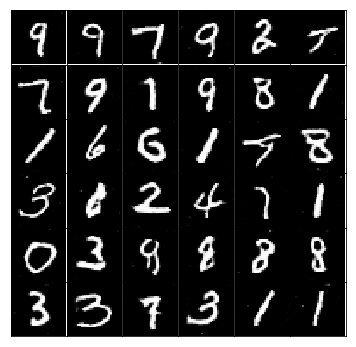

Epoch 11/25... Discriminator Loss: 1.1727... Generator Loss: 1.3973
Epoch 11/25... Discriminator Loss: 1.3201... Generator Loss: 0.4843
Epoch 11/25... Discriminator Loss: 1.1913... Generator Loss: 0.9248
Epoch 11/25... Discriminator Loss: 1.1261... Generator Loss: 0.4657
Epoch 11/25... Discriminator Loss: 1.7144... Generator Loss: 0.6062
Epoch 11/25... Discriminator Loss: 1.2194... Generator Loss: 1.3566
Epoch 11/25... Discriminator Loss: 1.1619... Generator Loss: 0.9873
Epoch 11/25... Discriminator Loss: 1.2718... Generator Loss: 0.6578
Dataset shuffled successfully.
Epoch 12/25... Discriminator Loss: 1.0442... Generator Loss: 0.8455
Epoch 12/25... Discriminator Loss: 1.2096... Generator Loss: 0.6025


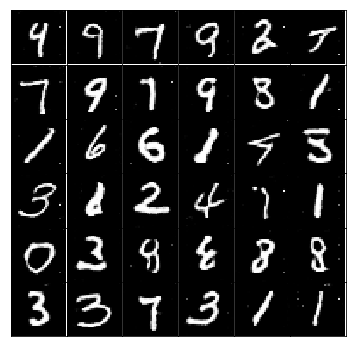

Epoch 12/25... Discriminator Loss: 1.1562... Generator Loss: 0.7096
Epoch 12/25... Discriminator Loss: 0.9999... Generator Loss: 0.7744
Epoch 12/25... Discriminator Loss: 1.1258... Generator Loss: 0.4960
Epoch 12/25... Discriminator Loss: 1.0784... Generator Loss: 0.4810
Epoch 12/25... Discriminator Loss: 1.0596... Generator Loss: 0.6275
Epoch 12/25... Discriminator Loss: 1.1723... Generator Loss: 0.7530
Epoch 12/25... Discriminator Loss: 0.9713... Generator Loss: 0.7849
Epoch 12/25... Discriminator Loss: 1.0153... Generator Loss: 0.8509
Epoch 12/25... Discriminator Loss: 1.0412... Generator Loss: 0.6101
Epoch 12/25... Discriminator Loss: 0.9969... Generator Loss: 1.0179


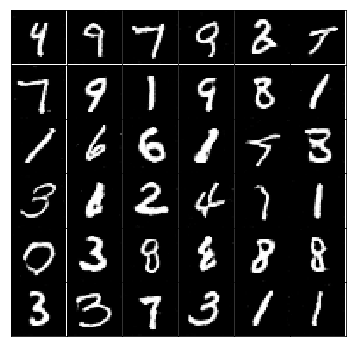

Epoch 12/25... Discriminator Loss: 1.2381... Generator Loss: 0.7752
Epoch 12/25... Discriminator Loss: 1.0304... Generator Loss: 0.6609
Epoch 12/25... Discriminator Loss: 1.0971... Generator Loss: 0.7442
Epoch 12/25... Discriminator Loss: 1.0150... Generator Loss: 0.8929
Epoch 12/25... Discriminator Loss: 1.2222... Generator Loss: 0.6892
Epoch 12/25... Discriminator Loss: 1.5525... Generator Loss: 0.3902
Epoch 12/25... Discriminator Loss: 1.0111... Generator Loss: 0.9068
Epoch 12/25... Discriminator Loss: 1.0273... Generator Loss: 1.0448
Epoch 12/25... Discriminator Loss: 1.1594... Generator Loss: 0.8077
Epoch 12/25... Discriminator Loss: 1.0804... Generator Loss: 0.5978


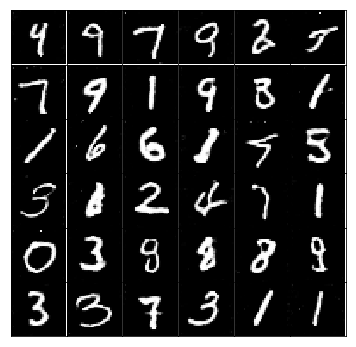

Epoch 12/25... Discriminator Loss: 1.0399... Generator Loss: 0.6593
Epoch 12/25... Discriminator Loss: 1.0635... Generator Loss: 0.9001
Epoch 12/25... Discriminator Loss: 1.4198... Generator Loss: 1.7416
Epoch 12/25... Discriminator Loss: 1.0396... Generator Loss: 0.5899
Epoch 12/25... Discriminator Loss: 1.1198... Generator Loss: 0.9130
Epoch 12/25... Discriminator Loss: 1.4560... Generator Loss: 0.3009
Epoch 12/25... Discriminator Loss: 1.1223... Generator Loss: 0.9724
Epoch 12/25... Discriminator Loss: 1.0863... Generator Loss: 1.1355
Epoch 12/25... Discriminator Loss: 1.0588... Generator Loss: 0.8870
Epoch 12/25... Discriminator Loss: 1.1027... Generator Loss: 1.2850


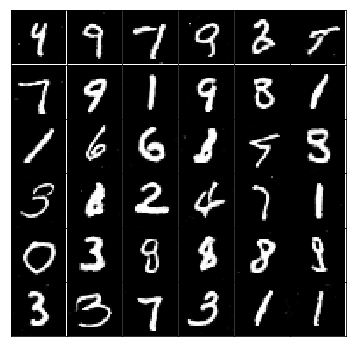

Epoch 12/25... Discriminator Loss: 1.1114... Generator Loss: 0.9449
Epoch 12/25... Discriminator Loss: 1.1028... Generator Loss: 0.7342
Epoch 12/25... Discriminator Loss: 1.0597... Generator Loss: 0.4508
Epoch 12/25... Discriminator Loss: 1.4140... Generator Loss: 2.0505
Epoch 12/25... Discriminator Loss: 0.9851... Generator Loss: 0.8286
Epoch 12/25... Discriminator Loss: 1.1281... Generator Loss: 0.7440
Epoch 12/25... Discriminator Loss: 1.0909... Generator Loss: 1.1297
Epoch 12/25... Discriminator Loss: 0.9908... Generator Loss: 0.6704
Epoch 12/25... Discriminator Loss: 1.1082... Generator Loss: 0.7660
Epoch 12/25... Discriminator Loss: 1.2128... Generator Loss: 1.3307


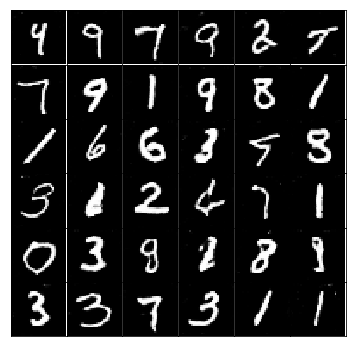

Epoch 12/25... Discriminator Loss: 1.0988... Generator Loss: 1.1781
Epoch 12/25... Discriminator Loss: 1.0103... Generator Loss: 0.6147
Epoch 12/25... Discriminator Loss: 1.1204... Generator Loss: 0.7742
Epoch 12/25... Discriminator Loss: 1.0802... Generator Loss: 0.6508
Epoch 12/25... Discriminator Loss: 1.5070... Generator Loss: 0.4545
Epoch 12/25... Discriminator Loss: 1.1044... Generator Loss: 0.5884
Epoch 12/25... Discriminator Loss: 1.0220... Generator Loss: 0.7969
Epoch 12/25... Discriminator Loss: 1.2974... Generator Loss: 0.3822
Epoch 12/25... Discriminator Loss: 1.1264... Generator Loss: 0.5890
Dataset shuffled successfully.
Epoch 13/25... Discriminator Loss: 1.0926... Generator Loss: 0.9049


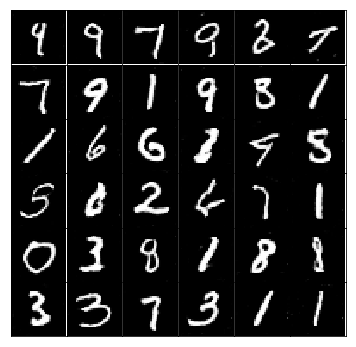

Epoch 13/25... Discriminator Loss: 1.0560... Generator Loss: 0.7877
Epoch 13/25... Discriminator Loss: 1.0168... Generator Loss: 0.8297
Epoch 13/25... Discriminator Loss: 1.2144... Generator Loss: 0.5138
Epoch 13/25... Discriminator Loss: 1.0735... Generator Loss: 0.8282
Epoch 13/25... Discriminator Loss: 1.0277... Generator Loss: 0.8040
Epoch 13/25... Discriminator Loss: 1.1236... Generator Loss: 0.8765
Epoch 13/25... Discriminator Loss: 1.0025... Generator Loss: 0.7384
Epoch 13/25... Discriminator Loss: 1.0406... Generator Loss: 0.7281
Epoch 13/25... Discriminator Loss: 1.1445... Generator Loss: 0.7845
Epoch 13/25... Discriminator Loss: 1.1541... Generator Loss: 1.3721


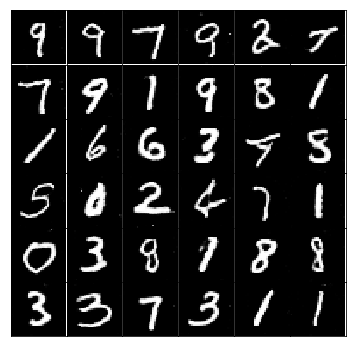

Epoch 13/25... Discriminator Loss: 0.9789... Generator Loss: 0.7812
Epoch 13/25... Discriminator Loss: 0.9986... Generator Loss: 1.0762
Epoch 13/25... Discriminator Loss: 0.9857... Generator Loss: 0.6648
Epoch 13/25... Discriminator Loss: 1.2220... Generator Loss: 1.5992
Epoch 13/25... Discriminator Loss: 1.0471... Generator Loss: 0.8339
Epoch 13/25... Discriminator Loss: 1.0434... Generator Loss: 1.0051
Epoch 13/25... Discriminator Loss: 0.9772... Generator Loss: 0.9214
Epoch 13/25... Discriminator Loss: 1.2279... Generator Loss: 0.9748
Epoch 13/25... Discriminator Loss: 1.1157... Generator Loss: 0.8180
Epoch 13/25... Discriminator Loss: 1.0773... Generator Loss: 1.3031


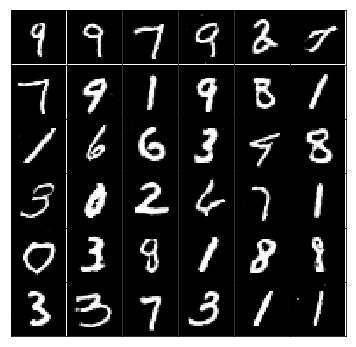

Epoch 13/25... Discriminator Loss: 1.0552... Generator Loss: 0.6885
Epoch 13/25... Discriminator Loss: 1.0120... Generator Loss: 0.8766
Epoch 13/25... Discriminator Loss: 1.0944... Generator Loss: 0.6085
Epoch 13/25... Discriminator Loss: 1.0647... Generator Loss: 0.8233
Epoch 13/25... Discriminator Loss: 1.2056... Generator Loss: 1.6328
Epoch 13/25... Discriminator Loss: 0.9860... Generator Loss: 0.9029
Epoch 13/25... Discriminator Loss: 1.0020... Generator Loss: 1.1128
Epoch 13/25... Discriminator Loss: 0.9602... Generator Loss: 0.8663
Epoch 13/25... Discriminator Loss: 1.0253... Generator Loss: 0.7072
Epoch 13/25... Discriminator Loss: 0.9898... Generator Loss: 1.0287


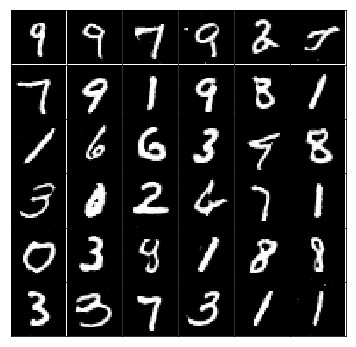

Epoch 13/25... Discriminator Loss: 0.9906... Generator Loss: 0.6315
Epoch 13/25... Discriminator Loss: 1.2530... Generator Loss: 1.9551
Epoch 13/25... Discriminator Loss: 1.0816... Generator Loss: 0.3678
Epoch 13/25... Discriminator Loss: 0.9545... Generator Loss: 0.7805
Epoch 13/25... Discriminator Loss: 1.0646... Generator Loss: 0.5658
Epoch 13/25... Discriminator Loss: 1.0797... Generator Loss: 0.9174
Epoch 13/25... Discriminator Loss: 0.9847... Generator Loss: 0.5494
Epoch 13/25... Discriminator Loss: 1.0034... Generator Loss: 1.0604
Epoch 13/25... Discriminator Loss: 1.3093... Generator Loss: 1.4776
Epoch 13/25... Discriminator Loss: 1.2433... Generator Loss: 0.5945


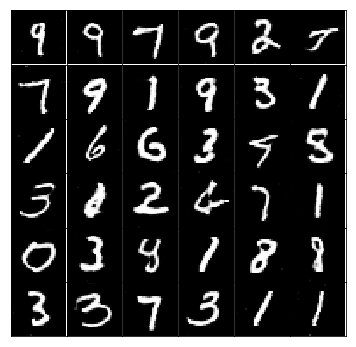

Epoch 13/25... Discriminator Loss: 0.9908... Generator Loss: 0.7464
Epoch 13/25... Discriminator Loss: 1.0458... Generator Loss: 0.6205
Epoch 13/25... Discriminator Loss: 1.0216... Generator Loss: 0.6087
Epoch 13/25... Discriminator Loss: 1.1160... Generator Loss: 0.8455
Epoch 13/25... Discriminator Loss: 1.3273... Generator Loss: 0.8814
Epoch 13/25... Discriminator Loss: 1.0269... Generator Loss: 1.0426
Epoch 13/25... Discriminator Loss: 0.9997... Generator Loss: 0.6361
Epoch 13/25... Discriminator Loss: 1.0159... Generator Loss: 0.7438
Epoch 13/25... Discriminator Loss: 1.1561... Generator Loss: 0.7605
Epoch 13/25... Discriminator Loss: 1.0552... Generator Loss: 0.7795


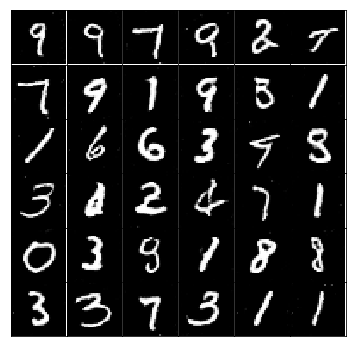

Dataset shuffled successfully.
Epoch 14/25... Discriminator Loss: 1.0484... Generator Loss: 0.5848
Epoch 14/25... Discriminator Loss: 1.0192... Generator Loss: 0.9040
Epoch 14/25... Discriminator Loss: 0.9356... Generator Loss: 0.8537
Epoch 14/25... Discriminator Loss: 1.1295... Generator Loss: 1.0188
Epoch 14/25... Discriminator Loss: 1.0719... Generator Loss: 0.5571
Epoch 14/25... Discriminator Loss: 1.0367... Generator Loss: 0.9205
Epoch 14/25... Discriminator Loss: 0.9932... Generator Loss: 0.6216
Epoch 14/25... Discriminator Loss: 1.0782... Generator Loss: 0.6760
Epoch 14/25... Discriminator Loss: 1.1202... Generator Loss: 0.9342
Epoch 14/25... Discriminator Loss: 1.1993... Generator Loss: 1.1856


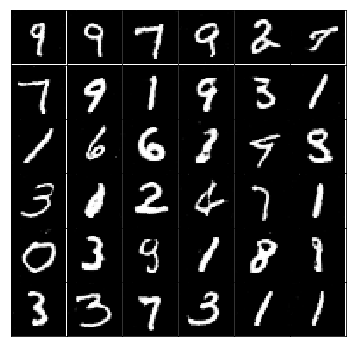

Epoch 14/25... Discriminator Loss: 1.1803... Generator Loss: 0.5008
Epoch 14/25... Discriminator Loss: 1.0407... Generator Loss: 0.5110
Epoch 14/25... Discriminator Loss: 1.0260... Generator Loss: 0.8969
Epoch 14/25... Discriminator Loss: 1.1681... Generator Loss: 0.6888
Epoch 14/25... Discriminator Loss: 1.1149... Generator Loss: 0.8599
Epoch 14/25... Discriminator Loss: 1.0454... Generator Loss: 0.7908
Epoch 14/25... Discriminator Loss: 1.2314... Generator Loss: 1.4873
Epoch 14/25... Discriminator Loss: 1.0463... Generator Loss: 0.9877
Epoch 14/25... Discriminator Loss: 1.0990... Generator Loss: 0.8251
Epoch 14/25... Discriminator Loss: 0.9873... Generator Loss: 0.6364


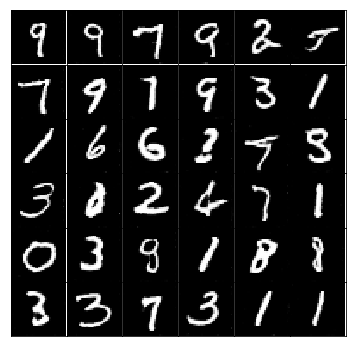

Epoch 14/25... Discriminator Loss: 1.0259... Generator Loss: 0.8059
Epoch 14/25... Discriminator Loss: 1.2430... Generator Loss: 0.4262
Epoch 14/25... Discriminator Loss: 0.9381... Generator Loss: 0.7811
Epoch 14/25... Discriminator Loss: 1.0353... Generator Loss: 0.7278
Epoch 14/25... Discriminator Loss: 1.0068... Generator Loss: 0.5686
Epoch 14/25... Discriminator Loss: 1.2430... Generator Loss: 1.9397
Epoch 14/25... Discriminator Loss: 1.0690... Generator Loss: 1.5504
Epoch 14/25... Discriminator Loss: 1.0600... Generator Loss: 0.7376
Epoch 14/25... Discriminator Loss: 1.0839... Generator Loss: 0.8256
Epoch 14/25... Discriminator Loss: 1.0213... Generator Loss: 0.5007


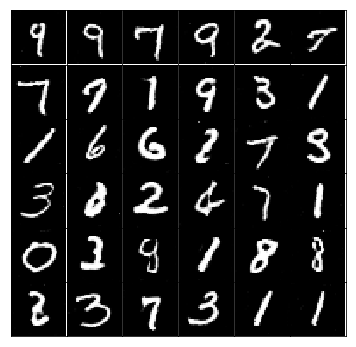

Epoch 14/25... Discriminator Loss: 1.0890... Generator Loss: 0.8837
Epoch 14/25... Discriminator Loss: 1.0772... Generator Loss: 0.8439
Epoch 14/25... Discriminator Loss: 1.0501... Generator Loss: 0.6957
Epoch 14/25... Discriminator Loss: 1.0018... Generator Loss: 0.9015
Epoch 14/25... Discriminator Loss: 0.9477... Generator Loss: 1.1055
Epoch 14/25... Discriminator Loss: 1.1574... Generator Loss: 1.5415
Epoch 14/25... Discriminator Loss: 1.0325... Generator Loss: 0.6900
Epoch 14/25... Discriminator Loss: 1.1043... Generator Loss: 0.9394
Epoch 14/25... Discriminator Loss: 1.0514... Generator Loss: 1.0695
Epoch 14/25... Discriminator Loss: 1.0581... Generator Loss: 0.9450


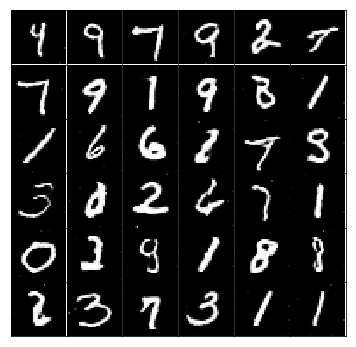

Epoch 14/25... Discriminator Loss: 2.0193... Generator Loss: 2.5754
Epoch 14/25... Discriminator Loss: 1.1489... Generator Loss: 0.9606
Epoch 14/25... Discriminator Loss: 1.1611... Generator Loss: 0.9578
Epoch 14/25... Discriminator Loss: 1.1840... Generator Loss: 1.4049
Epoch 14/25... Discriminator Loss: 1.0264... Generator Loss: 0.7509
Epoch 14/25... Discriminator Loss: 1.0151... Generator Loss: 1.0009
Epoch 14/25... Discriminator Loss: 1.2033... Generator Loss: 0.7288
Epoch 14/25... Discriminator Loss: 1.0145... Generator Loss: 0.7222
Epoch 14/25... Discriminator Loss: 1.5263... Generator Loss: 0.6966
Epoch 14/25... Discriminator Loss: 1.0148... Generator Loss: 0.8103


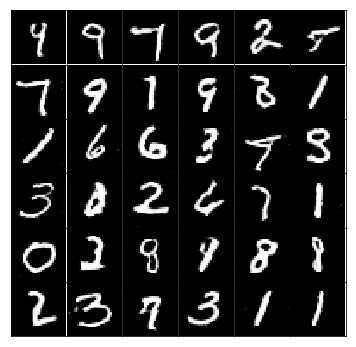

Epoch 14/25... Discriminator Loss: 1.1188... Generator Loss: 0.6256
Dataset shuffled successfully.
Epoch 15/25... Discriminator Loss: 1.2320... Generator Loss: 0.4803
Epoch 15/25... Discriminator Loss: 1.0425... Generator Loss: 0.7573
Epoch 15/25... Discriminator Loss: 1.0527... Generator Loss: 1.3205
Epoch 15/25... Discriminator Loss: 0.9795... Generator Loss: 0.5894
Epoch 15/25... Discriminator Loss: 1.0382... Generator Loss: 1.3150
Epoch 15/25... Discriminator Loss: 1.1065... Generator Loss: 1.3338
Epoch 15/25... Discriminator Loss: 1.0244... Generator Loss: 1.0652
Epoch 15/25... Discriminator Loss: 0.9999... Generator Loss: 0.9548
Epoch 15/25... Discriminator Loss: 0.9494... Generator Loss: 0.7596


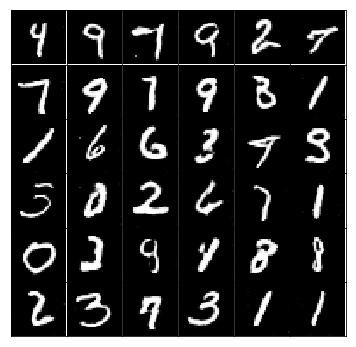

Epoch 15/25... Discriminator Loss: 1.1888... Generator Loss: 1.1303
Epoch 15/25... Discriminator Loss: 0.9698... Generator Loss: 0.8020
Epoch 15/25... Discriminator Loss: 1.0466... Generator Loss: 0.5539
Epoch 15/25... Discriminator Loss: 0.9970... Generator Loss: 1.0774
Epoch 15/25... Discriminator Loss: 1.0373... Generator Loss: 0.8529
Epoch 15/25... Discriminator Loss: 1.0699... Generator Loss: 0.8080
Epoch 15/25... Discriminator Loss: 1.0350... Generator Loss: 1.1666
Epoch 15/25... Discriminator Loss: 0.9783... Generator Loss: 0.7942
Epoch 15/25... Discriminator Loss: 1.0765... Generator Loss: 1.2232
Epoch 15/25... Discriminator Loss: 1.0664... Generator Loss: 0.9929


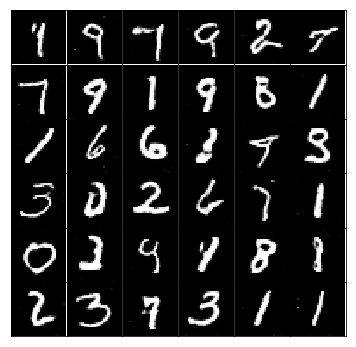

Epoch 15/25... Discriminator Loss: 0.9873... Generator Loss: 0.8867
Epoch 15/25... Discriminator Loss: 1.0021... Generator Loss: 0.6132
Epoch 15/25... Discriminator Loss: 1.1011... Generator Loss: 0.4248
Epoch 15/25... Discriminator Loss: 0.9458... Generator Loss: 0.8156
Epoch 15/25... Discriminator Loss: 0.9955... Generator Loss: 0.6758
Epoch 15/25... Discriminator Loss: 1.0769... Generator Loss: 0.9934
Epoch 15/25... Discriminator Loss: 1.3029... Generator Loss: 1.6527
Epoch 15/25... Discriminator Loss: 0.8701... Generator Loss: 0.8470
Epoch 15/25... Discriminator Loss: 0.9838... Generator Loss: 0.6237
Epoch 15/25... Discriminator Loss: 1.0394... Generator Loss: 0.8191


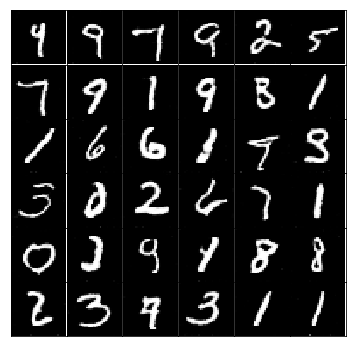

Epoch 15/25... Discriminator Loss: 1.1361... Generator Loss: 1.2935
Epoch 15/25... Discriminator Loss: 0.9312... Generator Loss: 0.6881
Epoch 15/25... Discriminator Loss: 1.1575... Generator Loss: 0.5165
Epoch 15/25... Discriminator Loss: 0.9731... Generator Loss: 0.6689
Epoch 15/25... Discriminator Loss: 1.1251... Generator Loss: 0.4101
Epoch 15/25... Discriminator Loss: 1.0983... Generator Loss: 0.8624
Epoch 15/25... Discriminator Loss: 0.9533... Generator Loss: 0.9368
Epoch 15/25... Discriminator Loss: 0.8977... Generator Loss: 0.7882
Epoch 15/25... Discriminator Loss: 0.9340... Generator Loss: 0.5864
Epoch 15/25... Discriminator Loss: 0.9703... Generator Loss: 0.7341


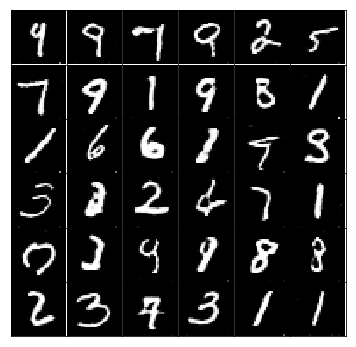

Epoch 15/25... Discriminator Loss: 0.9983... Generator Loss: 1.0285
Epoch 15/25... Discriminator Loss: 0.9399... Generator Loss: 0.8877
Epoch 15/25... Discriminator Loss: 1.0137... Generator Loss: 1.1817
Epoch 15/25... Discriminator Loss: 1.2081... Generator Loss: 0.4159
Epoch 15/25... Discriminator Loss: 1.2482... Generator Loss: 1.3036
Epoch 15/25... Discriminator Loss: 0.9642... Generator Loss: 0.6895
Epoch 15/25... Discriminator Loss: 0.8283... Generator Loss: 0.6553
Epoch 15/25... Discriminator Loss: 1.0081... Generator Loss: 0.8424
Epoch 15/25... Discriminator Loss: 1.0227... Generator Loss: 0.5837
Epoch 15/25... Discriminator Loss: 1.2436... Generator Loss: 1.8172


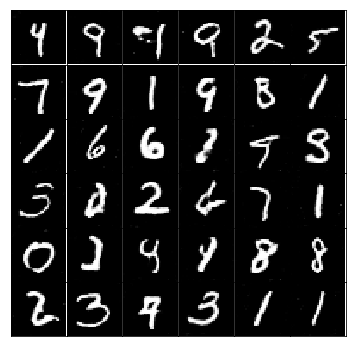

Epoch 15/25... Discriminator Loss: 1.1387... Generator Loss: 0.7047
Dataset shuffled successfully.
Epoch 16/25... Discriminator Loss: 1.2353... Generator Loss: 0.5821
Epoch 16/25... Discriminator Loss: 1.2896... Generator Loss: 0.4401
Epoch 16/25... Discriminator Loss: 0.9375... Generator Loss: 0.9425
Epoch 16/25... Discriminator Loss: 1.2704... Generator Loss: 0.4733
Epoch 16/25... Discriminator Loss: 1.1021... Generator Loss: 0.9890
Epoch 16/25... Discriminator Loss: 1.0295... Generator Loss: 1.1743
Epoch 16/25... Discriminator Loss: 1.1629... Generator Loss: 0.4962
Epoch 16/25... Discriminator Loss: 1.2657... Generator Loss: 0.5465
Epoch 16/25... Discriminator Loss: 1.0100... Generator Loss: 0.8950


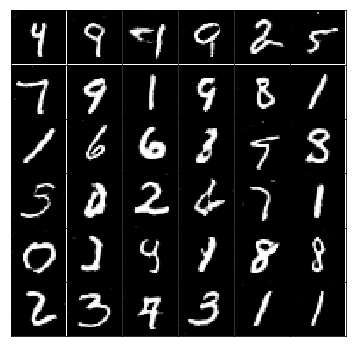

Epoch 16/25... Discriminator Loss: 1.1947... Generator Loss: 0.4837
Epoch 16/25... Discriminator Loss: 0.8336... Generator Loss: 0.7674
Epoch 16/25... Discriminator Loss: 1.5582... Generator Loss: 0.6087
Epoch 16/25... Discriminator Loss: 1.2153... Generator Loss: 0.4683
Epoch 16/25... Discriminator Loss: 0.9228... Generator Loss: 0.7791
Epoch 16/25... Discriminator Loss: 1.1881... Generator Loss: 0.3993
Epoch 16/25... Discriminator Loss: 1.0543... Generator Loss: 0.8709
Epoch 16/25... Discriminator Loss: 1.0283... Generator Loss: 1.1372
Epoch 16/25... Discriminator Loss: 1.1392... Generator Loss: 1.3893
Epoch 16/25... Discriminator Loss: 1.0348... Generator Loss: 0.6546


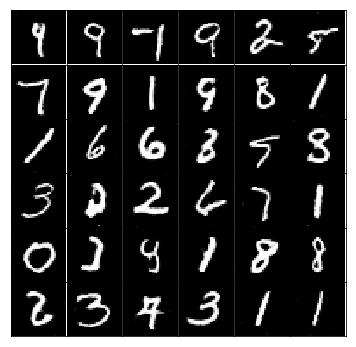

Epoch 16/25... Discriminator Loss: 1.0127... Generator Loss: 0.9807
Epoch 16/25... Discriminator Loss: 0.9939... Generator Loss: 0.7562
Epoch 16/25... Discriminator Loss: 0.8754... Generator Loss: 0.6514
Epoch 16/25... Discriminator Loss: 1.0109... Generator Loss: 0.8826
Epoch 16/25... Discriminator Loss: 0.9232... Generator Loss: 0.6518
Epoch 16/25... Discriminator Loss: 1.1530... Generator Loss: 1.6038
Epoch 16/25... Discriminator Loss: 1.2827... Generator Loss: 0.6493
Epoch 16/25... Discriminator Loss: 0.9015... Generator Loss: 0.9534
Epoch 16/25... Discriminator Loss: 1.0261... Generator Loss: 0.6688
Epoch 16/25... Discriminator Loss: 1.1439... Generator Loss: 1.5719


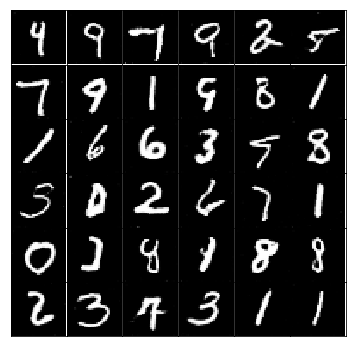

Epoch 16/25... Discriminator Loss: 1.0987... Generator Loss: 1.5067
Epoch 16/25... Discriminator Loss: 1.0036... Generator Loss: 1.4693
Epoch 16/25... Discriminator Loss: 1.2027... Generator Loss: 0.5037
Epoch 16/25... Discriminator Loss: 1.0404... Generator Loss: 1.3133
Epoch 16/25... Discriminator Loss: 0.9631... Generator Loss: 0.7830
Epoch 16/25... Discriminator Loss: 0.9690... Generator Loss: 0.5889
Epoch 16/25... Discriminator Loss: 0.9520... Generator Loss: 0.8749
Epoch 16/25... Discriminator Loss: 0.8526... Generator Loss: 0.8139
Epoch 16/25... Discriminator Loss: 1.1205... Generator Loss: 1.3601
Epoch 16/25... Discriminator Loss: 1.0407... Generator Loss: 0.7375


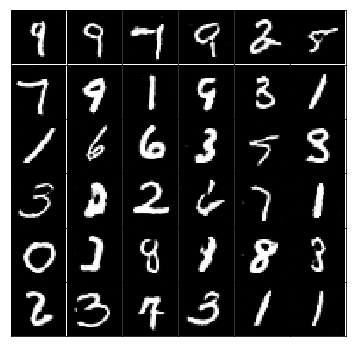

Epoch 16/25... Discriminator Loss: 1.0531... Generator Loss: 0.8085
Epoch 16/25... Discriminator Loss: 1.1460... Generator Loss: 1.3909
Epoch 16/25... Discriminator Loss: 1.0422... Generator Loss: 1.4592
Epoch 16/25... Discriminator Loss: 1.3246... Generator Loss: 0.4929
Epoch 16/25... Discriminator Loss: 1.3953... Generator Loss: 0.4150
Epoch 16/25... Discriminator Loss: 1.1019... Generator Loss: 0.9546
Epoch 16/25... Discriminator Loss: 1.0743... Generator Loss: 0.4714
Epoch 16/25... Discriminator Loss: 0.9979... Generator Loss: 1.0367
Epoch 16/25... Discriminator Loss: 0.8972... Generator Loss: 1.0188
Epoch 16/25... Discriminator Loss: 1.0536... Generator Loss: 1.0982


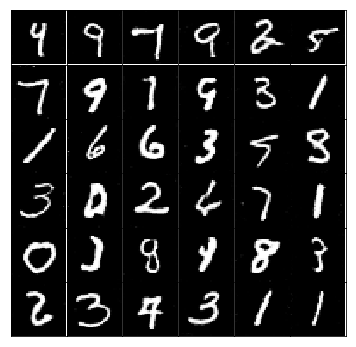

Epoch 16/25... Discriminator Loss: 0.8585... Generator Loss: 1.0843
Epoch 16/25... Discriminator Loss: 1.0813... Generator Loss: 0.9340
Dataset shuffled successfully.
Epoch 17/25... Discriminator Loss: 0.9147... Generator Loss: 0.7997
Epoch 17/25... Discriminator Loss: 1.0315... Generator Loss: 0.4877
Epoch 17/25... Discriminator Loss: 1.0147... Generator Loss: 0.7568
Epoch 17/25... Discriminator Loss: 0.8937... Generator Loss: 0.7954
Epoch 17/25... Discriminator Loss: 1.0604... Generator Loss: 1.2223
Epoch 17/25... Discriminator Loss: 1.0916... Generator Loss: 0.7497
Epoch 17/25... Discriminator Loss: 0.9387... Generator Loss: 0.8127
Epoch 17/25... Discriminator Loss: 0.9377... Generator Loss: 0.6106


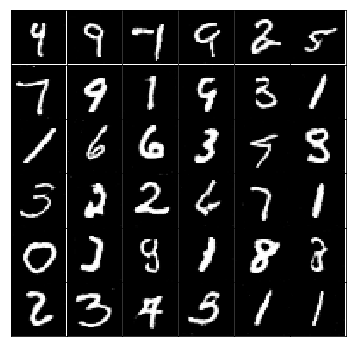

Epoch 17/25... Discriminator Loss: 1.1859... Generator Loss: 0.9552
Epoch 17/25... Discriminator Loss: 1.1111... Generator Loss: 0.8689
Epoch 17/25... Discriminator Loss: 0.9977... Generator Loss: 0.7539
Epoch 17/25... Discriminator Loss: 0.9408... Generator Loss: 0.7927
Epoch 17/25... Discriminator Loss: 0.9223... Generator Loss: 1.2079
Epoch 17/25... Discriminator Loss: 0.8969... Generator Loss: 0.7181
Epoch 17/25... Discriminator Loss: 0.8962... Generator Loss: 0.8433
Epoch 17/25... Discriminator Loss: 1.0323... Generator Loss: 0.9346
Epoch 17/25... Discriminator Loss: 0.9593... Generator Loss: 0.9882
Epoch 17/25... Discriminator Loss: 1.0563... Generator Loss: 0.5612


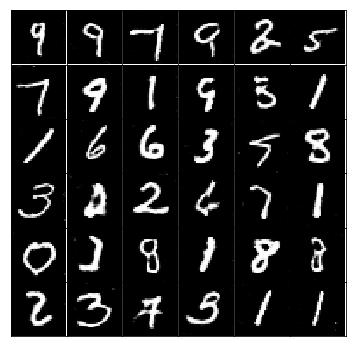

Epoch 17/25... Discriminator Loss: 0.9144... Generator Loss: 1.0083
Epoch 17/25... Discriminator Loss: 1.1184... Generator Loss: 0.6025
Epoch 17/25... Discriminator Loss: 1.1060... Generator Loss: 0.5512
Epoch 17/25... Discriminator Loss: 1.0531... Generator Loss: 1.5779
Epoch 17/25... Discriminator Loss: 0.9604... Generator Loss: 0.8951
Epoch 17/25... Discriminator Loss: 1.0392... Generator Loss: 0.4791
Epoch 17/25... Discriminator Loss: 1.4756... Generator Loss: 2.2057
Epoch 17/25... Discriminator Loss: 0.9291... Generator Loss: 0.7701
Epoch 17/25... Discriminator Loss: 0.9828... Generator Loss: 0.6740
Epoch 17/25... Discriminator Loss: 1.5459... Generator Loss: 0.6470


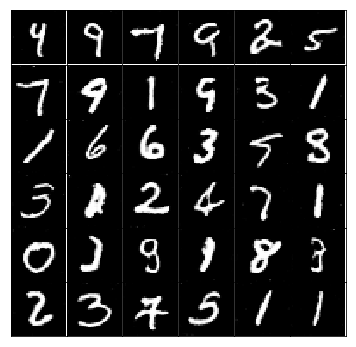

Epoch 17/25... Discriminator Loss: 1.2305... Generator Loss: 0.5001
Epoch 17/25... Discriminator Loss: 0.9544... Generator Loss: 0.8061
Epoch 17/25... Discriminator Loss: 1.0510... Generator Loss: 0.5408
Epoch 17/25... Discriminator Loss: 1.4105... Generator Loss: 0.7835
Epoch 17/25... Discriminator Loss: 1.0664... Generator Loss: 1.3711
Epoch 17/25... Discriminator Loss: 0.9147... Generator Loss: 0.8882
Epoch 17/25... Discriminator Loss: 1.1431... Generator Loss: 0.8356
Epoch 17/25... Discriminator Loss: 0.9740... Generator Loss: 0.7538
Epoch 17/25... Discriminator Loss: 1.0045... Generator Loss: 1.0944
Epoch 17/25... Discriminator Loss: 0.8760... Generator Loss: 0.9179


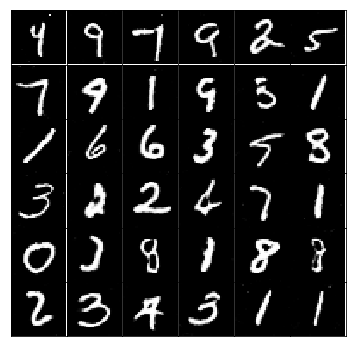

Epoch 17/25... Discriminator Loss: 0.8985... Generator Loss: 0.8318
Epoch 17/25... Discriminator Loss: 0.9350... Generator Loss: 0.7611
Epoch 17/25... Discriminator Loss: 0.9709... Generator Loss: 0.9345
Epoch 17/25... Discriminator Loss: 1.0019... Generator Loss: 1.4520
Epoch 17/25... Discriminator Loss: 1.3151... Generator Loss: 1.7911
Epoch 17/25... Discriminator Loss: 0.9878... Generator Loss: 0.6739
Epoch 17/25... Discriminator Loss: 0.9946... Generator Loss: 1.0871
Epoch 17/25... Discriminator Loss: 1.1274... Generator Loss: 1.3792
Epoch 17/25... Discriminator Loss: 1.0137... Generator Loss: 1.3657
Epoch 17/25... Discriminator Loss: 1.1592... Generator Loss: 1.6742


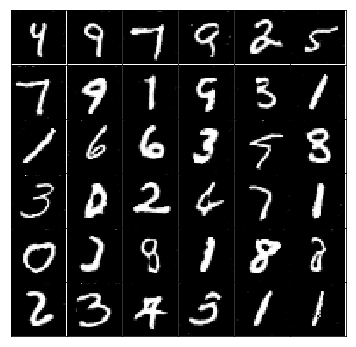

Epoch 17/25... Discriminator Loss: 1.0165... Generator Loss: 0.6823
Epoch 17/25... Discriminator Loss: 1.0922... Generator Loss: 1.2658
Epoch 17/25... Discriminator Loss: 1.2377... Generator Loss: 0.5119
Dataset shuffled successfully.
Epoch 18/25... Discriminator Loss: 1.0197... Generator Loss: 0.5709
Epoch 18/25... Discriminator Loss: 0.8017... Generator Loss: 0.7721
Epoch 18/25... Discriminator Loss: 0.9686... Generator Loss: 1.2840
Epoch 18/25... Discriminator Loss: 1.0598... Generator Loss: 0.8978
Epoch 18/25... Discriminator Loss: 1.1509... Generator Loss: 1.3844
Epoch 18/25... Discriminator Loss: 0.8903... Generator Loss: 0.6806
Epoch 18/25... Discriminator Loss: 0.8659... Generator Loss: 0.6814


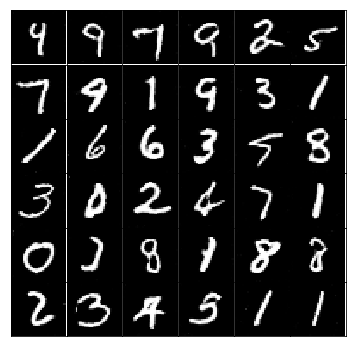

Epoch 18/25... Discriminator Loss: 1.1092... Generator Loss: 0.6273
Epoch 18/25... Discriminator Loss: 1.0577... Generator Loss: 0.6422
Epoch 18/25... Discriminator Loss: 0.8656... Generator Loss: 0.6811
Epoch 18/25... Discriminator Loss: 0.9493... Generator Loss: 0.6341
Epoch 18/25... Discriminator Loss: 1.1092... Generator Loss: 1.4965
Epoch 18/25... Discriminator Loss: 0.9976... Generator Loss: 1.2574
Epoch 18/25... Discriminator Loss: 1.0440... Generator Loss: 0.5768
Epoch 18/25... Discriminator Loss: 0.9181... Generator Loss: 0.7357
Epoch 18/25... Discriminator Loss: 1.0726... Generator Loss: 1.3565
Epoch 18/25... Discriminator Loss: 0.9951... Generator Loss: 1.5825


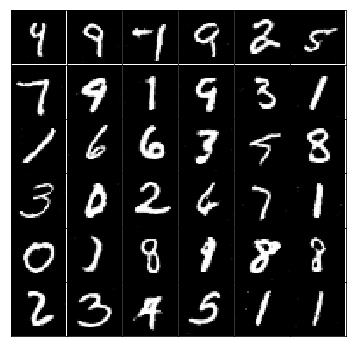

Epoch 18/25... Discriminator Loss: 0.9116... Generator Loss: 1.0249
Epoch 18/25... Discriminator Loss: 0.9878... Generator Loss: 0.5423
Epoch 18/25... Discriminator Loss: 1.1428... Generator Loss: 2.0426
Epoch 18/25... Discriminator Loss: 0.8978... Generator Loss: 0.7973
Epoch 18/25... Discriminator Loss: 1.0465... Generator Loss: 1.4862
Epoch 18/25... Discriminator Loss: 0.9669... Generator Loss: 1.0665
Epoch 18/25... Discriminator Loss: 1.2283... Generator Loss: 1.1778
Epoch 18/25... Discriminator Loss: 1.0506... Generator Loss: 0.7837
Epoch 18/25... Discriminator Loss: 0.9517... Generator Loss: 0.5650
Epoch 18/25... Discriminator Loss: 1.0495... Generator Loss: 0.5637


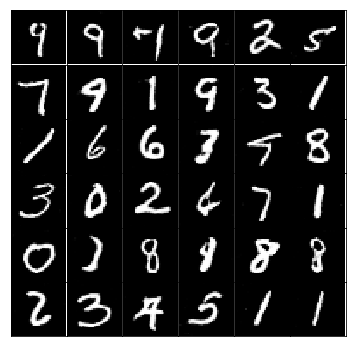

Epoch 18/25... Discriminator Loss: 1.1254... Generator Loss: 1.1136
Epoch 18/25... Discriminator Loss: 1.0073... Generator Loss: 0.6578
Epoch 18/25... Discriminator Loss: 0.9637... Generator Loss: 0.9333
Epoch 18/25... Discriminator Loss: 0.9586... Generator Loss: 0.8458
Epoch 18/25... Discriminator Loss: 1.1877... Generator Loss: 0.6174
Epoch 18/25... Discriminator Loss: 1.0144... Generator Loss: 1.0225
Epoch 18/25... Discriminator Loss: 0.9661... Generator Loss: 1.4030
Epoch 18/25... Discriminator Loss: 0.9045... Generator Loss: 0.9913
Epoch 18/25... Discriminator Loss: 0.9763... Generator Loss: 0.7472
Epoch 18/25... Discriminator Loss: 0.9437... Generator Loss: 0.7505


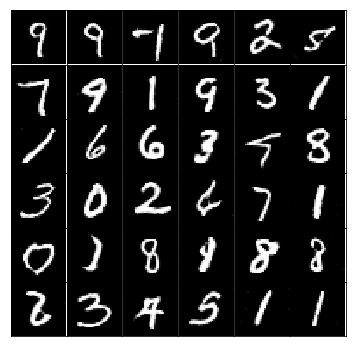

Epoch 18/25... Discriminator Loss: 1.0441... Generator Loss: 0.9029
Epoch 18/25... Discriminator Loss: 1.0054... Generator Loss: 0.6150
Epoch 18/25... Discriminator Loss: 1.1285... Generator Loss: 0.4585
Epoch 18/25... Discriminator Loss: 0.9193... Generator Loss: 0.7749
Epoch 18/25... Discriminator Loss: 0.9367... Generator Loss: 0.6352
Epoch 18/25... Discriminator Loss: 1.1001... Generator Loss: 0.7322
Epoch 18/25... Discriminator Loss: 0.9999... Generator Loss: 0.7538
Epoch 18/25... Discriminator Loss: 0.9633... Generator Loss: 1.0064
Epoch 18/25... Discriminator Loss: 1.0973... Generator Loss: 1.6232
Epoch 18/25... Discriminator Loss: 0.9292... Generator Loss: 0.9237


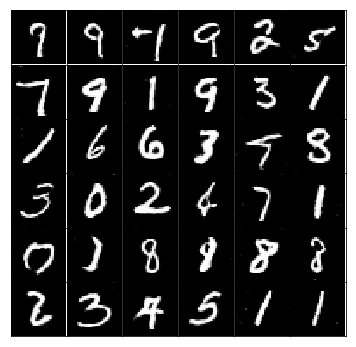

Epoch 18/25... Discriminator Loss: 1.0512... Generator Loss: 0.3952
Epoch 18/25... Discriminator Loss: 0.9308... Generator Loss: 0.7632
Epoch 18/25... Discriminator Loss: 1.3230... Generator Loss: 1.7298
Epoch 18/25... Discriminator Loss: 1.9424... Generator Loss: 0.5255
Dataset shuffled successfully.
Epoch 19/25... Discriminator Loss: 1.0542... Generator Loss: 0.5441
Epoch 19/25... Discriminator Loss: 0.9646... Generator Loss: 0.9864
Epoch 19/25... Discriminator Loss: 1.0855... Generator Loss: 1.0067
Epoch 19/25... Discriminator Loss: 0.9569... Generator Loss: 0.5532
Epoch 19/25... Discriminator Loss: 0.9537... Generator Loss: 0.5967
Epoch 19/25... Discriminator Loss: 1.0073... Generator Loss: 0.4693


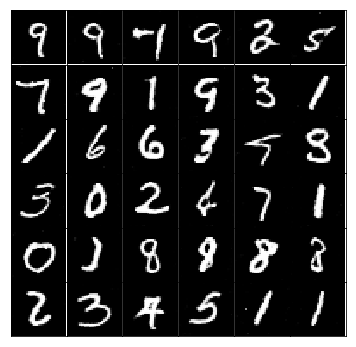

Epoch 19/25... Discriminator Loss: 1.2664... Generator Loss: 0.6174
Epoch 19/25... Discriminator Loss: 0.7906... Generator Loss: 0.9697
Epoch 19/25... Discriminator Loss: 0.8570... Generator Loss: 1.0498
Epoch 19/25... Discriminator Loss: 0.8738... Generator Loss: 0.9308
Epoch 19/25... Discriminator Loss: 1.2021... Generator Loss: 0.4762
Epoch 19/25... Discriminator Loss: 0.9220... Generator Loss: 0.7755
Epoch 19/25... Discriminator Loss: 1.1154... Generator Loss: 0.4787
Epoch 19/25... Discriminator Loss: 1.0077... Generator Loss: 1.1155
Epoch 19/25... Discriminator Loss: 0.9007... Generator Loss: 0.5941
Epoch 19/25... Discriminator Loss: 0.8456... Generator Loss: 0.7125


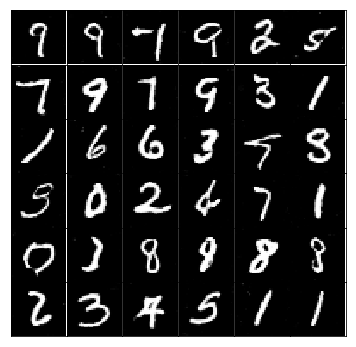

Epoch 19/25... Discriminator Loss: 0.9575... Generator Loss: 0.6221
Epoch 19/25... Discriminator Loss: 1.0364... Generator Loss: 1.2266
Epoch 19/25... Discriminator Loss: 0.9434... Generator Loss: 0.7872
Epoch 19/25... Discriminator Loss: 1.0350... Generator Loss: 0.5547
Epoch 19/25... Discriminator Loss: 1.0964... Generator Loss: 2.2975
Epoch 19/25... Discriminator Loss: 1.1875... Generator Loss: 1.6824
Epoch 19/25... Discriminator Loss: 0.8774... Generator Loss: 0.8724
Epoch 19/25... Discriminator Loss: 1.1074... Generator Loss: 0.9641
Epoch 19/25... Discriminator Loss: 0.9684... Generator Loss: 0.5990
Epoch 19/25... Discriminator Loss: 1.0541... Generator Loss: 0.9258


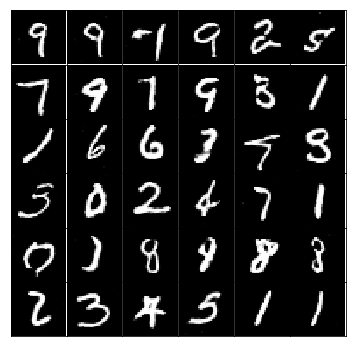

Epoch 19/25... Discriminator Loss: 1.0192... Generator Loss: 1.1838
Epoch 19/25... Discriminator Loss: 0.9459... Generator Loss: 0.9806
Epoch 19/25... Discriminator Loss: 1.1150... Generator Loss: 0.5116
Epoch 19/25... Discriminator Loss: 0.9101... Generator Loss: 0.9206
Epoch 19/25... Discriminator Loss: 0.8382... Generator Loss: 0.9271
Epoch 19/25... Discriminator Loss: 1.1933... Generator Loss: 1.2207
Epoch 19/25... Discriminator Loss: 0.9317... Generator Loss: 0.7499
Epoch 19/25... Discriminator Loss: 0.9390... Generator Loss: 0.9043
Epoch 19/25... Discriminator Loss: 0.8936... Generator Loss: 0.6961
Epoch 19/25... Discriminator Loss: 1.0939... Generator Loss: 1.2317


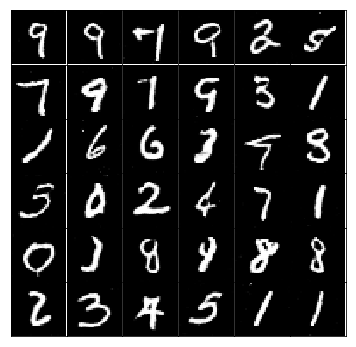

Epoch 19/25... Discriminator Loss: 1.0616... Generator Loss: 0.7905
Epoch 19/25... Discriminator Loss: 1.0514... Generator Loss: 1.0797
Epoch 19/25... Discriminator Loss: 0.9050... Generator Loss: 0.7203
Epoch 19/25... Discriminator Loss: 0.9742... Generator Loss: 1.2083
Epoch 19/25... Discriminator Loss: 1.0362... Generator Loss: 0.5650
Epoch 19/25... Discriminator Loss: 1.0513... Generator Loss: 1.3938
Epoch 19/25... Discriminator Loss: 0.9480... Generator Loss: 0.7844
Epoch 19/25... Discriminator Loss: 1.1274... Generator Loss: 0.4734
Epoch 19/25... Discriminator Loss: 0.9807... Generator Loss: 0.5969
Epoch 19/25... Discriminator Loss: 0.9976... Generator Loss: 0.7785


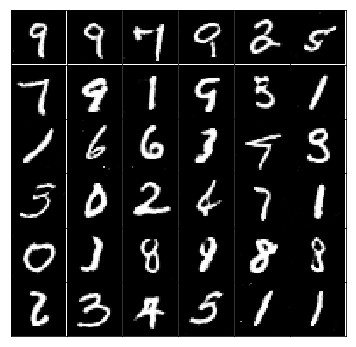

Epoch 19/25... Discriminator Loss: 1.0086... Generator Loss: 1.1121
Epoch 19/25... Discriminator Loss: 1.3923... Generator Loss: 1.7703
Epoch 19/25... Discriminator Loss: 0.8795... Generator Loss: 0.9723
Epoch 19/25... Discriminator Loss: 1.0685... Generator Loss: 1.1524
Epoch 19/25... Discriminator Loss: 1.0813... Generator Loss: 0.7137
Dataset shuffled successfully.
Epoch 20/25... Discriminator Loss: 0.9843... Generator Loss: 1.2442
Epoch 20/25... Discriminator Loss: 0.9472... Generator Loss: 0.8529
Epoch 20/25... Discriminator Loss: 1.1672... Generator Loss: 0.9366
Epoch 20/25... Discriminator Loss: 0.7889... Generator Loss: 0.8851
Epoch 20/25... Discriminator Loss: 1.4193... Generator Loss: 0.5275


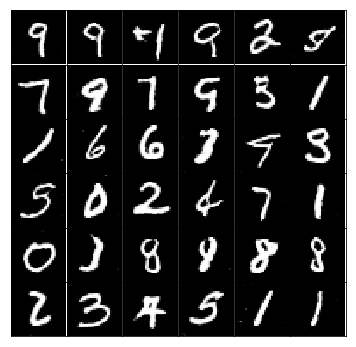

Epoch 20/25... Discriminator Loss: 0.8961... Generator Loss: 0.8647
Epoch 20/25... Discriminator Loss: 1.0141... Generator Loss: 1.4779
Epoch 20/25... Discriminator Loss: 0.9978... Generator Loss: 1.2053
Epoch 20/25... Discriminator Loss: 1.0227... Generator Loss: 1.0332
Epoch 20/25... Discriminator Loss: 1.2671... Generator Loss: 0.4872
Epoch 20/25... Discriminator Loss: 1.0589... Generator Loss: 1.3344
Epoch 20/25... Discriminator Loss: 1.4001... Generator Loss: 0.3584
Epoch 20/25... Discriminator Loss: 0.8936... Generator Loss: 0.8219
Epoch 20/25... Discriminator Loss: 0.9118... Generator Loss: 1.2081
Epoch 20/25... Discriminator Loss: 1.4071... Generator Loss: 1.8937


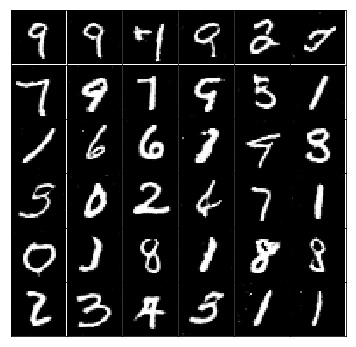

Epoch 20/25... Discriminator Loss: 1.1383... Generator Loss: 1.9508
Epoch 20/25... Discriminator Loss: 0.9491... Generator Loss: 0.9650
Epoch 20/25... Discriminator Loss: 0.8954... Generator Loss: 0.6770
Epoch 20/25... Discriminator Loss: 1.2428... Generator Loss: 1.3535
Epoch 20/25... Discriminator Loss: 0.8857... Generator Loss: 0.7341
Epoch 20/25... Discriminator Loss: 1.1659... Generator Loss: 1.2187
Epoch 20/25... Discriminator Loss: 0.8514... Generator Loss: 0.8261
Epoch 20/25... Discriminator Loss: 1.0393... Generator Loss: 0.3946
Epoch 20/25... Discriminator Loss: 0.8625... Generator Loss: 1.2252
Epoch 20/25... Discriminator Loss: 1.0136... Generator Loss: 1.7137


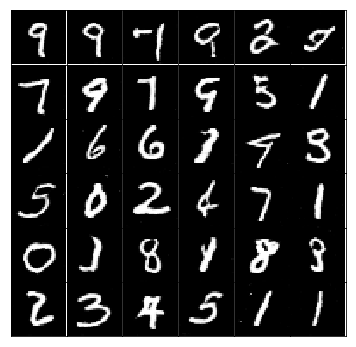

Epoch 20/25... Discriminator Loss: 0.9443... Generator Loss: 0.8269
Epoch 20/25... Discriminator Loss: 0.8019... Generator Loss: 1.0788
Epoch 20/25... Discriminator Loss: 0.7665... Generator Loss: 1.1132
Epoch 20/25... Discriminator Loss: 1.0559... Generator Loss: 1.5979
Epoch 20/25... Discriminator Loss: 1.0867... Generator Loss: 1.0857
Epoch 20/25... Discriminator Loss: 0.9762... Generator Loss: 0.8048
Epoch 20/25... Discriminator Loss: 0.7907... Generator Loss: 0.9286
Epoch 20/25... Discriminator Loss: 1.1149... Generator Loss: 0.4056
Epoch 20/25... Discriminator Loss: 0.8479... Generator Loss: 0.7835
Epoch 20/25... Discriminator Loss: 0.9775... Generator Loss: 1.2718


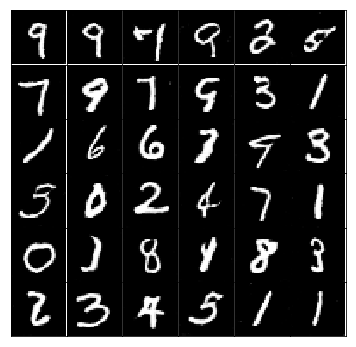

Epoch 20/25... Discriminator Loss: 1.0644... Generator Loss: 1.4854
Epoch 20/25... Discriminator Loss: 1.0305... Generator Loss: 0.5933
Epoch 20/25... Discriminator Loss: 0.9701... Generator Loss: 1.1740
Epoch 20/25... Discriminator Loss: 0.9055... Generator Loss: 0.8212
Epoch 20/25... Discriminator Loss: 0.7989... Generator Loss: 0.8549
Epoch 20/25... Discriminator Loss: 0.9498... Generator Loss: 0.7046
Epoch 20/25... Discriminator Loss: 1.0965... Generator Loss: 1.5993
Epoch 20/25... Discriminator Loss: 1.0357... Generator Loss: 1.5768
Epoch 20/25... Discriminator Loss: 0.9137... Generator Loss: 0.5979
Epoch 20/25... Discriminator Loss: 0.9667... Generator Loss: 0.5634


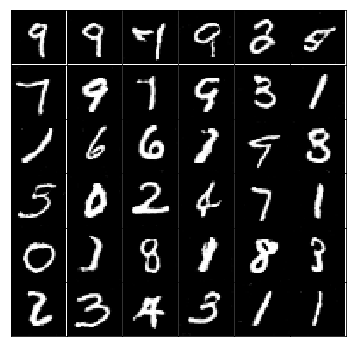

Epoch 20/25... Discriminator Loss: 0.8852... Generator Loss: 0.7162
Epoch 20/25... Discriminator Loss: 1.0028... Generator Loss: 0.6467
Epoch 20/25... Discriminator Loss: 1.1803... Generator Loss: 1.6934
Epoch 20/25... Discriminator Loss: 1.0445... Generator Loss: 1.4646
Epoch 20/25... Discriminator Loss: 0.9558... Generator Loss: 1.3387
Dataset shuffled successfully.
Epoch 21/25... Discriminator Loss: 0.9287... Generator Loss: 0.6392
Epoch 21/25... Discriminator Loss: 1.1298... Generator Loss: 0.5852
Epoch 21/25... Discriminator Loss: 0.9941... Generator Loss: 0.4689
Epoch 21/25... Discriminator Loss: 0.9787... Generator Loss: 0.8362
Epoch 21/25... Discriminator Loss: 1.0228... Generator Loss: 0.8523


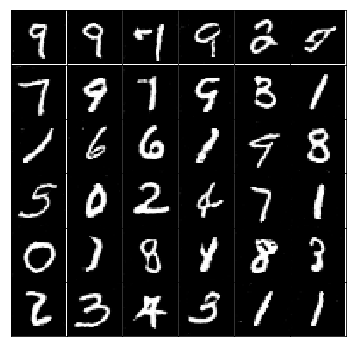

Epoch 21/25... Discriminator Loss: 1.0940... Generator Loss: 1.8239
Epoch 21/25... Discriminator Loss: 0.9917... Generator Loss: 1.0235
Epoch 21/25... Discriminator Loss: 0.9509... Generator Loss: 0.6688
Epoch 21/25... Discriminator Loss: 1.2617... Generator Loss: 1.8489
Epoch 21/25... Discriminator Loss: 1.0074... Generator Loss: 0.9588
Epoch 21/25... Discriminator Loss: 1.0429... Generator Loss: 0.8746
Epoch 21/25... Discriminator Loss: 0.9853... Generator Loss: 0.6980
Epoch 21/25... Discriminator Loss: 0.9246... Generator Loss: 0.7070
Epoch 21/25... Discriminator Loss: 0.8132... Generator Loss: 0.5820
Epoch 21/25... Discriminator Loss: 1.0476... Generator Loss: 0.6793


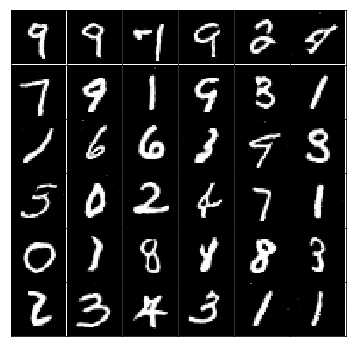

Epoch 21/25... Discriminator Loss: 1.0999... Generator Loss: 0.6395
Epoch 21/25... Discriminator Loss: 0.9552... Generator Loss: 0.9562
Epoch 21/25... Discriminator Loss: 0.7944... Generator Loss: 0.5597
Epoch 21/25... Discriminator Loss: 0.9427... Generator Loss: 0.9137
Epoch 21/25... Discriminator Loss: 0.9511... Generator Loss: 0.4435
Epoch 21/25... Discriminator Loss: 1.0274... Generator Loss: 0.6254
Epoch 21/25... Discriminator Loss: 1.1823... Generator Loss: 1.4338
Epoch 21/25... Discriminator Loss: 1.1350... Generator Loss: 1.2660
Epoch 21/25... Discriminator Loss: 0.8299... Generator Loss: 0.9198
Epoch 21/25... Discriminator Loss: 0.9340... Generator Loss: 0.7186


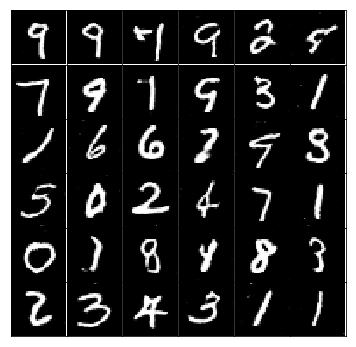

Epoch 21/25... Discriminator Loss: 0.9700... Generator Loss: 1.3122
Epoch 21/25... Discriminator Loss: 0.9485... Generator Loss: 0.6567
Epoch 21/25... Discriminator Loss: 0.8137... Generator Loss: 1.0108
Epoch 21/25... Discriminator Loss: 0.8444... Generator Loss: 0.7203
Epoch 21/25... Discriminator Loss: 0.9125... Generator Loss: 0.6158
Epoch 21/25... Discriminator Loss: 0.9333... Generator Loss: 0.7829
Epoch 21/25... Discriminator Loss: 0.8771... Generator Loss: 1.1055
Epoch 21/25... Discriminator Loss: 1.0367... Generator Loss: 0.5122
Epoch 21/25... Discriminator Loss: 0.9381... Generator Loss: 0.9515
Epoch 21/25... Discriminator Loss: 0.9488... Generator Loss: 0.6219


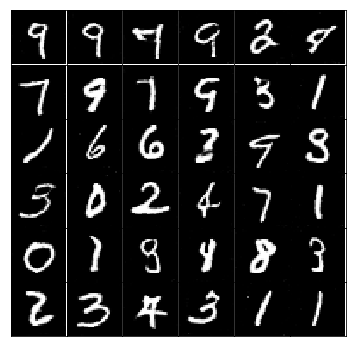

Epoch 21/25... Discriminator Loss: 0.8472... Generator Loss: 0.6173
Epoch 21/25... Discriminator Loss: 0.9494... Generator Loss: 1.5336
Epoch 21/25... Discriminator Loss: 0.7808... Generator Loss: 1.1032
Epoch 21/25... Discriminator Loss: 0.8761... Generator Loss: 0.8995
Epoch 21/25... Discriminator Loss: 0.9867... Generator Loss: 1.4613
Epoch 21/25... Discriminator Loss: 1.3462... Generator Loss: 2.3092
Epoch 21/25... Discriminator Loss: 0.9129... Generator Loss: 0.8161
Epoch 21/25... Discriminator Loss: 0.9004... Generator Loss: 0.9035
Epoch 21/25... Discriminator Loss: 0.9119... Generator Loss: 0.8616
Epoch 21/25... Discriminator Loss: 1.0709... Generator Loss: 1.4017


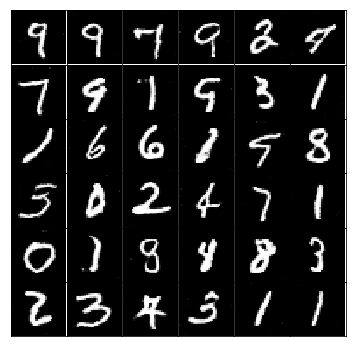

Epoch 21/25... Discriminator Loss: 1.2063... Generator Loss: 2.0278
Epoch 21/25... Discriminator Loss: 1.1042... Generator Loss: 0.7146
Epoch 21/25... Discriminator Loss: 0.9198... Generator Loss: 0.4688
Epoch 21/25... Discriminator Loss: 0.9435... Generator Loss: 0.7844
Epoch 21/25... Discriminator Loss: 1.1942... Generator Loss: 0.4735
Epoch 21/25... Discriminator Loss: 1.2793... Generator Loss: 2.0310
Dataset shuffled successfully.
Epoch 22/25... Discriminator Loss: 0.8697... Generator Loss: 0.7836
Epoch 22/25... Discriminator Loss: 0.9744... Generator Loss: 0.9358
Epoch 22/25... Discriminator Loss: 1.0070... Generator Loss: 1.2293
Epoch 22/25... Discriminator Loss: 0.8834... Generator Loss: 0.6586


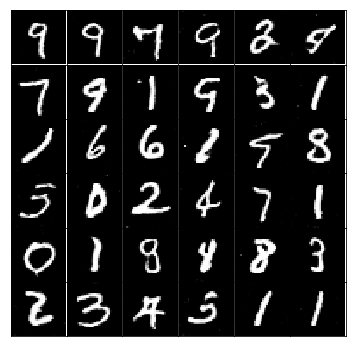

Epoch 22/25... Discriminator Loss: 0.8985... Generator Loss: 0.9771
Epoch 22/25... Discriminator Loss: 0.9072... Generator Loss: 1.2134
Epoch 22/25... Discriminator Loss: 0.9137... Generator Loss: 1.0988
Epoch 22/25... Discriminator Loss: 0.9649... Generator Loss: 0.9883
Epoch 22/25... Discriminator Loss: 0.9368... Generator Loss: 0.8589
Epoch 22/25... Discriminator Loss: 0.9218... Generator Loss: 0.4705
Epoch 22/25... Discriminator Loss: 1.2485... Generator Loss: 1.6743
Epoch 22/25... Discriminator Loss: 0.8533... Generator Loss: 1.0872
Epoch 22/25... Discriminator Loss: 0.8449... Generator Loss: 0.9320
Epoch 22/25... Discriminator Loss: 0.9254... Generator Loss: 0.7397


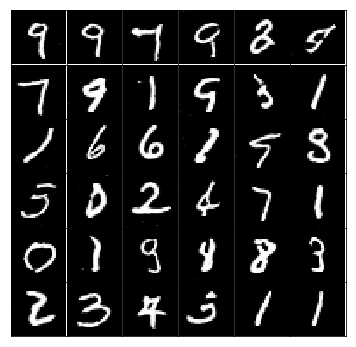

Epoch 22/25... Discriminator Loss: 1.0557... Generator Loss: 1.3326
Epoch 22/25... Discriminator Loss: 0.9025... Generator Loss: 1.2134
Epoch 22/25... Discriminator Loss: 0.9153... Generator Loss: 0.8837
Epoch 22/25... Discriminator Loss: 1.0559... Generator Loss: 0.6519
Epoch 22/25... Discriminator Loss: 1.0000... Generator Loss: 0.6022
Epoch 22/25... Discriminator Loss: 0.9985... Generator Loss: 0.8833
Epoch 22/25... Discriminator Loss: 0.8955... Generator Loss: 0.8937
Epoch 22/25... Discriminator Loss: 0.8556... Generator Loss: 0.7806
Epoch 22/25... Discriminator Loss: 0.8604... Generator Loss: 0.7732
Epoch 22/25... Discriminator Loss: 1.0950... Generator Loss: 1.2369


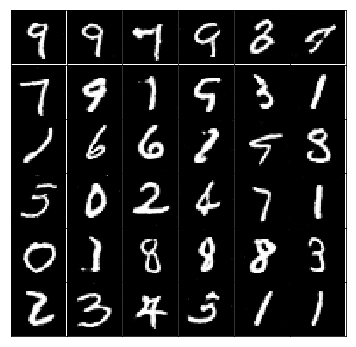

Epoch 22/25... Discriminator Loss: 0.9305... Generator Loss: 0.6161
Epoch 22/25... Discriminator Loss: 0.8268... Generator Loss: 0.8122
Epoch 22/25... Discriminator Loss: 0.9383... Generator Loss: 0.9137
Epoch 22/25... Discriminator Loss: 1.0442... Generator Loss: 0.4462
Epoch 22/25... Discriminator Loss: 0.9630... Generator Loss: 1.0741
Epoch 22/25... Discriminator Loss: 0.8209... Generator Loss: 0.8579
Epoch 22/25... Discriminator Loss: 0.7984... Generator Loss: 0.5230
Epoch 22/25... Discriminator Loss: 0.9990... Generator Loss: 0.7964
Epoch 22/25... Discriminator Loss: 0.9306... Generator Loss: 0.7190
Epoch 22/25... Discriminator Loss: 0.9609... Generator Loss: 1.2603


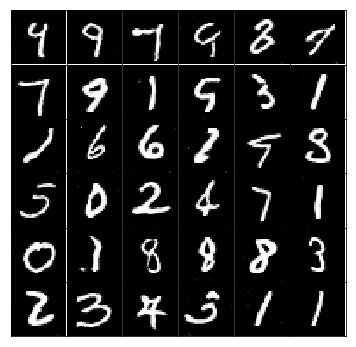

Epoch 22/25... Discriminator Loss: 0.7813... Generator Loss: 0.8547
Epoch 22/25... Discriminator Loss: 0.9162... Generator Loss: 0.8617
Epoch 22/25... Discriminator Loss: 1.0261... Generator Loss: 0.7943
Epoch 22/25... Discriminator Loss: 1.0625... Generator Loss: 1.5040
Epoch 22/25... Discriminator Loss: 1.0965... Generator Loss: 0.9644
Epoch 22/25... Discriminator Loss: 0.9066... Generator Loss: 1.0517
Epoch 22/25... Discriminator Loss: 1.1034... Generator Loss: 1.5826
Epoch 22/25... Discriminator Loss: 1.0517... Generator Loss: 0.9860
Epoch 22/25... Discriminator Loss: 0.9053... Generator Loss: 1.0304
Epoch 22/25... Discriminator Loss: 0.9461... Generator Loss: 0.6981


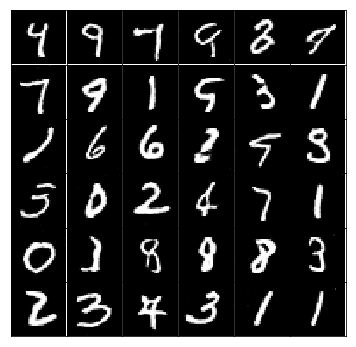

Epoch 22/25... Discriminator Loss: 0.8805... Generator Loss: 0.9895
Epoch 22/25... Discriminator Loss: 0.8564... Generator Loss: 0.9834
Epoch 22/25... Discriminator Loss: 1.4671... Generator Loss: 2.5454
Epoch 22/25... Discriminator Loss: 0.9122... Generator Loss: 1.1859
Epoch 22/25... Discriminator Loss: 0.9947... Generator Loss: 0.4733
Epoch 22/25... Discriminator Loss: 1.0459... Generator Loss: 0.9518
Epoch 22/25... Discriminator Loss: 0.9767... Generator Loss: 1.3847
Dataset shuffled successfully.
Epoch 23/25... Discriminator Loss: 0.8958... Generator Loss: 0.7530
Epoch 23/25... Discriminator Loss: 0.8947... Generator Loss: 1.0106
Epoch 23/25... Discriminator Loss: 0.9570... Generator Loss: 0.8917


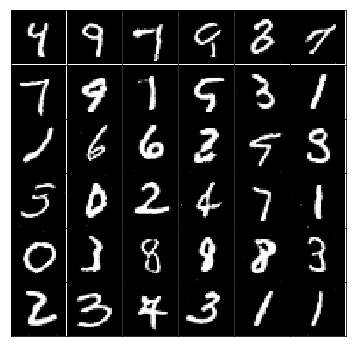

Epoch 23/25... Discriminator Loss: 0.8795... Generator Loss: 1.2961
Epoch 23/25... Discriminator Loss: 0.9286... Generator Loss: 0.6897
Epoch 23/25... Discriminator Loss: 0.8351... Generator Loss: 1.0781
Epoch 23/25... Discriminator Loss: 0.8506... Generator Loss: 0.5669
Epoch 23/25... Discriminator Loss: 0.8650... Generator Loss: 1.0027
Epoch 23/25... Discriminator Loss: 0.8983... Generator Loss: 0.5333
Epoch 23/25... Discriminator Loss: 0.8069... Generator Loss: 0.7789
Epoch 23/25... Discriminator Loss: 0.9881... Generator Loss: 0.8094
Epoch 23/25... Discriminator Loss: 0.8529... Generator Loss: 0.8318
Epoch 23/25... Discriminator Loss: 0.9780... Generator Loss: 1.6085


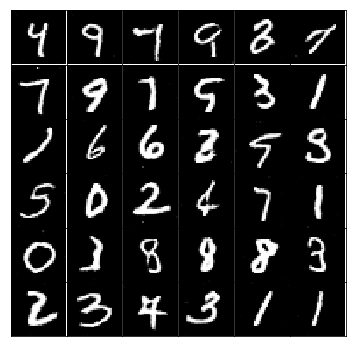

Epoch 23/25... Discriminator Loss: 0.8672... Generator Loss: 0.6536
Epoch 23/25... Discriminator Loss: 0.8850... Generator Loss: 1.2678
Epoch 23/25... Discriminator Loss: 0.9528... Generator Loss: 1.4742
Epoch 23/25... Discriminator Loss: 0.9289... Generator Loss: 1.2240
Epoch 23/25... Discriminator Loss: 0.9528... Generator Loss: 0.4421
Epoch 23/25... Discriminator Loss: 0.7996... Generator Loss: 1.0229
Epoch 23/25... Discriminator Loss: 0.7854... Generator Loss: 0.9032
Epoch 23/25... Discriminator Loss: 1.0642... Generator Loss: 0.8342
Epoch 23/25... Discriminator Loss: 0.8572... Generator Loss: 0.6432
Epoch 23/25... Discriminator Loss: 1.0019... Generator Loss: 0.4121


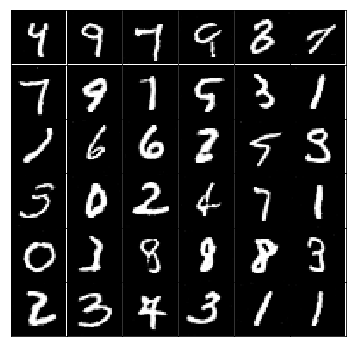

Epoch 23/25... Discriminator Loss: 1.0808... Generator Loss: 1.1127
Epoch 23/25... Discriminator Loss: 0.9601... Generator Loss: 0.6986
Epoch 23/25... Discriminator Loss: 0.9011... Generator Loss: 0.4814
Epoch 23/25... Discriminator Loss: 0.9380... Generator Loss: 0.7631
Epoch 23/25... Discriminator Loss: 0.9038... Generator Loss: 0.6492
Epoch 23/25... Discriminator Loss: 0.9736... Generator Loss: 1.2270
Epoch 23/25... Discriminator Loss: 0.9791... Generator Loss: 0.5771
Epoch 23/25... Discriminator Loss: 1.1140... Generator Loss: 1.5960
Epoch 23/25... Discriminator Loss: 0.9181... Generator Loss: 0.5722
Epoch 23/25... Discriminator Loss: 1.0306... Generator Loss: 0.5760


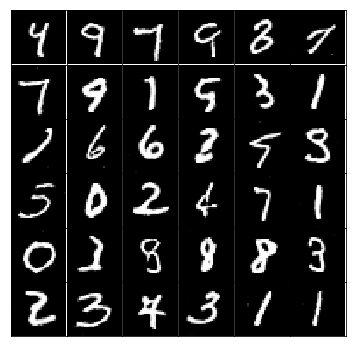

Epoch 23/25... Discriminator Loss: 1.0848... Generator Loss: 0.4242
Epoch 23/25... Discriminator Loss: 0.9085... Generator Loss: 0.6689
Epoch 23/25... Discriminator Loss: 0.9498... Generator Loss: 0.6601
Epoch 23/25... Discriminator Loss: 1.0365... Generator Loss: 0.8059
Epoch 23/25... Discriminator Loss: 0.9470... Generator Loss: 1.0106
Epoch 23/25... Discriminator Loss: 0.8262... Generator Loss: 0.5174
Epoch 23/25... Discriminator Loss: 0.8513... Generator Loss: 0.8352
Epoch 23/25... Discriminator Loss: 1.0779... Generator Loss: 1.8954
Epoch 23/25... Discriminator Loss: 0.8033... Generator Loss: 1.3163
Epoch 23/25... Discriminator Loss: 0.8312... Generator Loss: 0.9640


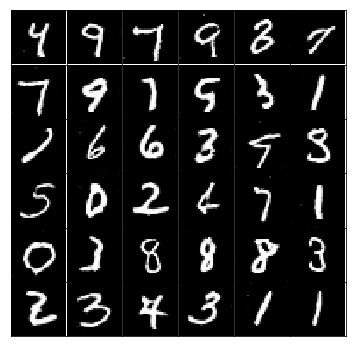

Epoch 23/25... Discriminator Loss: 1.4874... Generator Loss: 0.5207
Epoch 23/25... Discriminator Loss: 0.9288... Generator Loss: 1.0333
Epoch 23/25... Discriminator Loss: 0.8043... Generator Loss: 0.5926
Epoch 23/25... Discriminator Loss: 0.8823... Generator Loss: 0.6869
Epoch 23/25... Discriminator Loss: 0.8794... Generator Loss: 0.6689
Epoch 23/25... Discriminator Loss: 0.9487... Generator Loss: 0.5557
Epoch 23/25... Discriminator Loss: 1.0272... Generator Loss: 0.6179
Epoch 23/25... Discriminator Loss: 1.1593... Generator Loss: 1.8470
Dataset shuffled successfully.
Epoch 24/25... Discriminator Loss: 1.0501... Generator Loss: 0.6644
Epoch 24/25... Discriminator Loss: 0.8163... Generator Loss: 0.6707


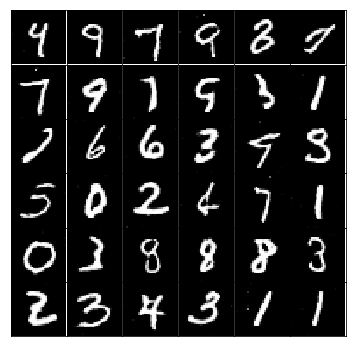

Epoch 24/25... Discriminator Loss: 0.8806... Generator Loss: 0.5701
Epoch 24/25... Discriminator Loss: 1.1618... Generator Loss: 0.6029
Epoch 24/25... Discriminator Loss: 0.8727... Generator Loss: 0.5020
Epoch 24/25... Discriminator Loss: 0.8915... Generator Loss: 0.5857
Epoch 24/25... Discriminator Loss: 0.8305... Generator Loss: 1.1205
Epoch 24/25... Discriminator Loss: 0.9298... Generator Loss: 1.5698
Epoch 24/25... Discriminator Loss: 0.9015... Generator Loss: 0.7350
Epoch 24/25... Discriminator Loss: 0.8614... Generator Loss: 0.7712
Epoch 24/25... Discriminator Loss: 0.9749... Generator Loss: 1.0328
Epoch 24/25... Discriminator Loss: 0.9051... Generator Loss: 0.4664


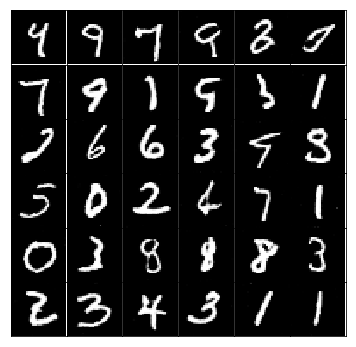

Epoch 24/25... Discriminator Loss: 1.0550... Generator Loss: 0.4855
Epoch 24/25... Discriminator Loss: 1.1166... Generator Loss: 0.6769
Epoch 24/25... Discriminator Loss: 0.8232... Generator Loss: 0.6625
Epoch 24/25... Discriminator Loss: 0.8452... Generator Loss: 1.4402
Epoch 24/25... Discriminator Loss: 0.9846... Generator Loss: 1.3291
Epoch 24/25... Discriminator Loss: 0.8333... Generator Loss: 0.7104
Epoch 24/25... Discriminator Loss: 0.9432... Generator Loss: 0.6227
Epoch 24/25... Discriminator Loss: 0.9308... Generator Loss: 0.8473
Epoch 24/25... Discriminator Loss: 0.9635... Generator Loss: 1.3194
Epoch 24/25... Discriminator Loss: 0.9892... Generator Loss: 0.4610


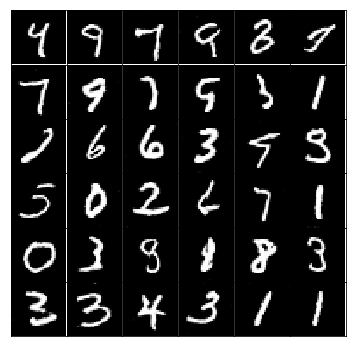

Epoch 24/25... Discriminator Loss: 0.8060... Generator Loss: 0.7081
Epoch 24/25... Discriminator Loss: 1.4596... Generator Loss: 0.6018
Epoch 24/25... Discriminator Loss: 0.9113... Generator Loss: 1.4421
Epoch 24/25... Discriminator Loss: 0.8473... Generator Loss: 0.9010
Epoch 24/25... Discriminator Loss: 1.1028... Generator Loss: 0.9595
Epoch 24/25... Discriminator Loss: 0.7967... Generator Loss: 0.8066
Epoch 24/25... Discriminator Loss: 1.0417... Generator Loss: 0.5870
Epoch 24/25... Discriminator Loss: 0.8377... Generator Loss: 1.1224
Epoch 24/25... Discriminator Loss: 0.8177... Generator Loss: 0.9537
Epoch 24/25... Discriminator Loss: 1.0901... Generator Loss: 1.6717


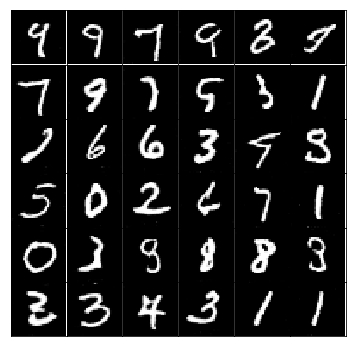

Epoch 24/25... Discriminator Loss: 0.9870... Generator Loss: 0.4857
Epoch 24/25... Discriminator Loss: 1.1667... Generator Loss: 0.6098
Epoch 24/25... Discriminator Loss: 1.0755... Generator Loss: 1.2239
Epoch 24/25... Discriminator Loss: 0.9136... Generator Loss: 1.3855
Epoch 24/25... Discriminator Loss: 0.9324... Generator Loss: 0.9284
Epoch 24/25... Discriminator Loss: 1.0184... Generator Loss: 0.7170
Epoch 24/25... Discriminator Loss: 0.8157... Generator Loss: 1.0959
Epoch 24/25... Discriminator Loss: 0.8981... Generator Loss: 0.4085
Epoch 24/25... Discriminator Loss: 0.9130... Generator Loss: 0.6740
Epoch 24/25... Discriminator Loss: 1.0553... Generator Loss: 1.5501


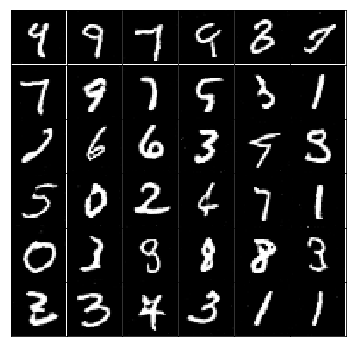

Epoch 24/25... Discriminator Loss: 0.9270... Generator Loss: 1.1532
Epoch 24/25... Discriminator Loss: 0.8318... Generator Loss: 1.0255
Epoch 24/25... Discriminator Loss: 1.1115... Generator Loss: 0.4189
Epoch 24/25... Discriminator Loss: 0.9699... Generator Loss: 0.9143
Epoch 24/25... Discriminator Loss: 0.9511... Generator Loss: 0.9966
Epoch 24/25... Discriminator Loss: 0.9264... Generator Loss: 0.6092
Epoch 24/25... Discriminator Loss: 0.8436... Generator Loss: 0.8968
Epoch 24/25... Discriminator Loss: 0.8789... Generator Loss: 1.0759
Epoch 24/25... Discriminator Loss: 0.9486... Generator Loss: 0.6344
Dataset shuffled successfully.
Epoch 25/25... Discriminator Loss: 0.8677... Generator Loss: 0.6423


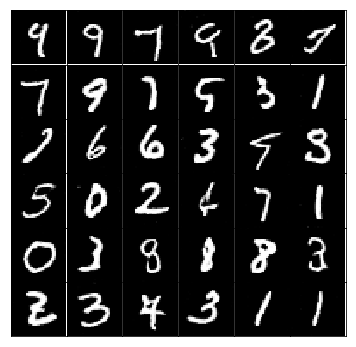

Epoch 25/25... Discriminator Loss: 0.8619... Generator Loss: 1.7456
Epoch 25/25... Discriminator Loss: 0.8519... Generator Loss: 0.9664
Epoch 25/25... Discriminator Loss: 0.9572... Generator Loss: 0.9230
Epoch 25/25... Discriminator Loss: 0.9306... Generator Loss: 0.6782
Epoch 25/25... Discriminator Loss: 0.7832... Generator Loss: 0.9733
Epoch 25/25... Discriminator Loss: 0.7621... Generator Loss: 0.9105
Epoch 25/25... Discriminator Loss: 0.8696... Generator Loss: 0.8184
Epoch 25/25... Discriminator Loss: 0.8565... Generator Loss: 1.4919
Epoch 25/25... Discriminator Loss: 0.8363... Generator Loss: 0.6942
Epoch 25/25... Discriminator Loss: 0.8621... Generator Loss: 0.8223


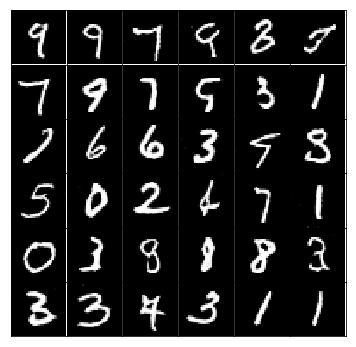

Epoch 25/25... Discriminator Loss: 0.9046... Generator Loss: 1.3672
Epoch 25/25... Discriminator Loss: 0.9373... Generator Loss: 0.6905
Epoch 25/25... Discriminator Loss: 0.8515... Generator Loss: 1.2510
Epoch 25/25... Discriminator Loss: 0.8031... Generator Loss: 0.9174
Epoch 25/25... Discriminator Loss: 0.9342... Generator Loss: 0.3638
Epoch 25/25... Discriminator Loss: 0.8737... Generator Loss: 0.8865
Epoch 25/25... Discriminator Loss: 0.7911... Generator Loss: 0.7361
Epoch 25/25... Discriminator Loss: 0.9443... Generator Loss: 0.6778
Epoch 25/25... Discriminator Loss: 0.7927... Generator Loss: 1.2192
Epoch 25/25... Discriminator Loss: 1.0823... Generator Loss: 2.0436


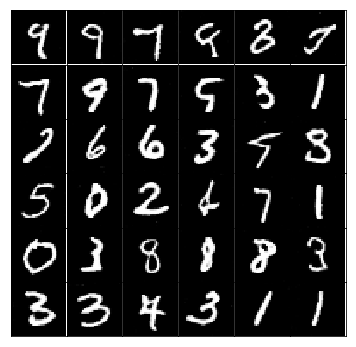

Epoch 25/25... Discriminator Loss: 0.9150... Generator Loss: 1.1446
Epoch 25/25... Discriminator Loss: 0.9358... Generator Loss: 0.6836
Epoch 25/25... Discriminator Loss: 0.8240... Generator Loss: 0.9775
Epoch 25/25... Discriminator Loss: 0.8337... Generator Loss: 1.6619
Epoch 25/25... Discriminator Loss: 1.0646... Generator Loss: 1.1475
Epoch 25/25... Discriminator Loss: 0.9927... Generator Loss: 1.1566
Epoch 25/25... Discriminator Loss: 0.8092... Generator Loss: 1.0265
Epoch 25/25... Discriminator Loss: 0.9467... Generator Loss: 1.2933
Epoch 25/25... Discriminator Loss: 0.8594... Generator Loss: 0.7455
Epoch 25/25... Discriminator Loss: 0.9254... Generator Loss: 0.6861


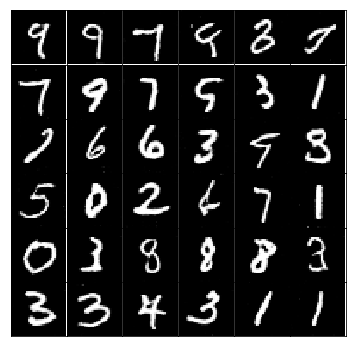

Epoch 25/25... Discriminator Loss: 0.9098... Generator Loss: 0.8706
Epoch 25/25... Discriminator Loss: 0.9074... Generator Loss: 1.0723
Epoch 25/25... Discriminator Loss: 1.1697... Generator Loss: 0.4699
Epoch 25/25... Discriminator Loss: 0.9678... Generator Loss: 1.2803
Epoch 25/25... Discriminator Loss: 1.0542... Generator Loss: 2.0035
Epoch 25/25... Discriminator Loss: 0.8424... Generator Loss: 0.8433
Epoch 25/25... Discriminator Loss: 0.9544... Generator Loss: 0.5986
Epoch 25/25... Discriminator Loss: 0.9746... Generator Loss: 0.8403
Epoch 25/25... Discriminator Loss: 0.9696... Generator Loss: 2.0741
Epoch 25/25... Discriminator Loss: 1.1341... Generator Loss: 1.4869


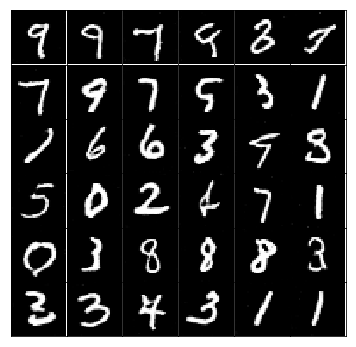

Epoch 25/25... Discriminator Loss: 0.9923... Generator Loss: 1.2324
Epoch 25/25... Discriminator Loss: 0.9186... Generator Loss: 0.8055
Epoch 25/25... Discriminator Loss: 1.0334... Generator Loss: 0.8357
Epoch 25/25... Discriminator Loss: 1.3712... Generator Loss: 0.3036
Epoch 25/25... Discriminator Loss: 0.9124... Generator Loss: 1.0168
Epoch 25/25... Discriminator Loss: 1.1247... Generator Loss: 0.7556
Epoch 25/25... Discriminator Loss: 0.9557... Generator Loss: 1.1977
Epoch 25/25... Discriminator Loss: 0.8591... Generator Loss: 0.8355
Epoch 25/25... Discriminator Loss: 0.9198... Generator Loss: 1.5910


In [15]:
import time

steps = 0
with tf.Session() as sess:
    # Merge all the summaries and write them out
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./logdir/' + str(time.time()), sess.graph)
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x in dataset.next_batch(batch_size):
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

            # Update the discriminator network
            _, summary, train_loss_d = sess.run([d_opt, merged, d_loss], feed_dict={input_real: x, input_z: batch_z})
            
            # Update the generator twice two avoid the rapid convergence of the discriminator
            _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x})
            _, train_loss_g = sess.run([g_opt, g_loss], feed_dict={input_z: batch_z, input_real: x})

            if steps % 10 == 0:
                train_writer.add_summary(summary, steps)

                print("Epoch {}/{}...".format(e+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
            
            if steps % 100 == 0:
                # At the end of each batch, sample some data from the generator, display and save it.
                # Notice when the generator creates the samples to displaied, we set training to False. 
                # That is important for signalling the batch normalization layers to use the population statistics rather 
                # than the batch statistics
                gen_samples = sess.run(
                               generator(input_z, real_size[2], reuse=True, training=False),
                               feed_dict={input_z: sample_z})
  
                display_images(gen_samples, denomalize=True)

                # save the samples to disk
                folder = "./video"
                if not os.path.isdir(folder):
                    os.makedirs(folder)

                plt.savefig(folder + "/file%02d.png" % image_counter)
                image_counter += 1
                plt.show()
                
            steps += 1

In [16]:
import matplotlib.cm as cm
import os
import subprocess
import glob
from os.path import isdir

video_name = 'video_mnist.mp4'
def generate_video(folder="./video"):
    cwd = os.getcwd()
    if not isdir(folder):
        os.makedirs(folder)
    os.chdir(folder)
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_' + dataset_name + '.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
    os.chdir(cwd)

In [17]:
generate_video()